Studend: Nozomu Nakanishi
Student Id: 2020264
Github:
CA 2 - Big Data / Advanced Data Analytics - 17/11/23

- Importing the necessary libraries for the practical part.

In [1]:
from pyspark.sql import SparkSession
import sparknlp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import to_date, to_timestamp
from pyspark.sql import functions as F
from pyspark.sql.functions import col, explode, expr, lit, regexp_replace, lower, split, size, length
from pyspark import StorageLevel
import pandas as pd
import matplotlib.pyplot as plt

- To avoid repetitions when commenting the code, codes such as .show() will not be commented. Because, more than 50% of them were used just for the Spark "lazyness" (to trigger the command).  

### Initializing Spark sessiong and Importing the dataset ProjectTweets.

In [2]:
# Initialize Spark Session with recommended settings for Spark NLP
spark = SparkSession.builder \
    .appName("ProjectTweets") \
    .master("local[*]") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryo.registrator", "com.johnsnowlabs.nlp.serialization.SparkNLPKryoRegistrator") \
    .getOrCreate()

In [3]:
# Defines the schema of the CSV file (ProjectTweets.csv) and adjust the field names and types for the dataframe.
tweetSchema = StructType([
    StructField("sequence", IntegerType(), True),
    StructField("ids", StringType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
])

# Imports the dataset in csv format.
df = spark.read.csv("file:///home/hduser/Desktop/CA2/ProjectTweets.csv", header=False, schema=tweetSchema)

In [4]:
df.show(5, truncate=False)

+--------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|sequence|ids       |date                        |flag    |user           |text                                                                                                               |
+--------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0       |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|1       |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|2       |1467810917|Mon Apr 06 22:19:53

In [5]:
# Number of rows
num_rows = df.count()

# Number of columns
num_columns = len(df.columns)

# Print out the shape
print(f"The DataFrame shape is: ({num_rows}, {num_columns})")

The DataFrame shape is: (1600000, 6)


- As presented in the .show, the dataframe called df has 6 columns and 1.6 millions of observations. 

In [6]:
# Prints the df schema. 
df.printSchema()

# Which shows that the types of the data are ones set in previous steps.

root
 |-- sequence: integer (nullable = true)
 |-- ids: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



- It was observable that the dates have a pacific day time (PDT) and the present notebook it has a different time zone, thus setting the time zone to PDT.

In [7]:
# Sets the time zone to PDT, the same as the date column.
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "America/Los_Angeles")

In [8]:
# Creating a new column where the date has a format that is better to perform analysis and models.
# Features like the day of the week and time zone are not necessary. 
date_format = "EEE MMM dd HH:mm:ss zzz yyyy"
# Parses the date e creates a new column dates with a shorter format, but with the necessary data. 
df = df.withColumn("dates", from_unixtime(unix_timestamp("date", date_format)))
df.show()

+--------+----------+--------------------+--------+---------------+--------------------+-------------------+
|sequence|       ids|                date|    flag|           user|                text|              dates|
+--------+----------+--------------------+--------+---------------+--------------------+-------------------+
|       0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|2009-04-06 22:19:45|
|       1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|2009-04-06 22:19:49|
|       2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|2009-04-06 22:19:53|
|       3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|2009-04-06 22:19:57|
|       4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|2009-04-06 22:19:57|
|       5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|2009-04-06 22:20:00|
|       6|146781159

### MISSING VALUES (TEXT COLUMN) AND DUPLICATES (TWITTER ID)

- The missing values will be searched through the tweets column, since the first objective is to extract the sentiment. 
- The duplicates will be searched through the twitter Id column, since is a unique identifier for each tweet, any duplicates will be further removed. 

In [9]:
# Find the count of missing values in the 'text' column
missing_values_count = df.filter(df.text.isNull()).count()
print(f"Number of missing values in 'text' column: {missing_values_count}")

# To find duplicates based on the 'ids' column
duplicates_count = df.groupBy('ids').count().filter("`count` > 1").count()
print(f"Number of duplicate ids: {duplicates_count}")

Number of missing values in 'text' column: 0


Number of duplicate ids: 1685


In [10]:
# To find duplicates based on the 'ids' column
duplicates_count = df.groupBy('ids').count().filter("`count` > 1").count()
print(f"Number of duplicate ids: {duplicates_count}")

Number of duplicate ids: 1685


In [11]:
df = df.dropDuplicates(['ids'])

# Now you can check the count of the DataFrame to ensure duplicates have been removed.
print(f"Count after dropping duplicates: {df.count()}")

Count after dropping duplicates: 1598315


- No presence of empty cells in the dataframe, however 1685 duplicates were found and removed. Reducing the number of observations to 1,598,315.

- Next step will drop columns that do not have purpose in the analysis and extraction.

In [12]:
df = df.drop("date", "ids", "user", "flag")
df.show()

+--------+--------------------+-------------------+
|sequence|                text|              dates|
+--------+--------------------+-------------------+
|       0|@switchfoot http:...|2009-04-06 22:19:45|
|       1|is upset that he ...|2009-04-06 22:19:49|
|       3|my whole body fee...|2009-04-06 22:19:57|
|       6|         Need a hug |2009-04-06 22:20:03|
|       8|@Tatiana_K nope t...|2009-04-06 22:20:05|
|       9|@twittera que me ...|2009-04-06 22:20:09|
|      12|@caregiving I cou...|2009-04-06 22:20:19|
|      15|@iamjazzyfizzle I...|2009-04-06 22:20:20|
|      18|@LettyA ahh ive a...|2009-04-06 22:20:31|
|      20|@alydesigns i was...|2009-04-06 22:20:37|
|      21|one of my friend ...|2009-04-06 22:20:38|
|      29|Meh... Almost Lov...|2009-04-06 22:21:04|
|      31|@alielayus I want...|2009-04-06 22:21:07|
|      33|@julieebaby awe i...|2009-04-06 22:21:11|
|      34|@HumpNinja I cry ...|2009-04-06 22:21:21|
|      35|ok I'm sick and s...|2009-04-06 22:21:20|
|      36|@c

- The column sequence was kept because it contains the original sequence of the dataframe, so in case of any shuffling the original sequence can be called. 

- Next stage will be performed the pre-processing of the tweets.  

# Pre-processing of the tweets and sentiment extraction.

- This step is separeted by two main lines of code, the first will normalized the tweets, by removing url, tags, mentions and character which has no meaning in sentiment extraction. The second is a pipeline from sparkNLP to generate and extract data that it is required to sentiment analysis over time and forecasting. 

- Both of the approaches will attempt to leverage the potential of Spark tools, such as the regex and the Natural Language Processing (NLP) tool, where it has numerous options from the simplest detection to deep learning. 

In [13]:
# Remove URLs
df = df.withColumn("text", F.regexp_replace(F.col("text"), "http(s)?://[^\\s]+", ""))

# Remove HTML tags
df = df.withColumn("text", F.regexp_replace(F.col("text"), "<[^>]+>", ""))

# Remove mentions (i.e., @username)
df = df.withColumn("text", F.regexp_replace(F.col("text"), "@\\w+", ""))

# Convert to lowercase
df = df.withColumn('text', lower(df['text']))

# Remove numbers from the "text" column
df = df.withColumn('text', regexp_replace(df['text'], r'\d+', ''))

# Reduce excessive characters (more than two of the same in a row)
df = df.withColumn('text', regexp_replace('text', r'(.)\1{2,}', r'\1\1'))

# Remove punctuation
df = df.withColumn('text', regexp_replace(df['text'], r"[^\w\s]", ""))

df.select("text").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------+
|   a11 thats a bummer  you shoulda got david carr of third day to do it d                                                    |
|is upset that he cant update his facebook by texting it11 and might cry as a result  school today also blah                  |
| i dived many times for the ball managed to save   the rest go out of bounds                                                 |
|my whole body feels itchy and like its on fire                                                                               |
|need a hug                                                                                             

In [14]:
# Counts the entries with URLs.
url_count = df.filter(F.col("text").rlike("http(s)?://([\\w-]+\\.)+[\\w-]+(/[\\w- ./?%&=]*)?")).count()

# Counts the entries with HTML tags.
html_tags_count = df.filter(F.col("text").rlike("<[^>]+>")).count()

# Counts the entries with mentions (@username).
mentions_count = df.filter(F.col("text").rlike("@\\w+")).count()

print(f"Number of entries with URLs: {url_count}")
print(f"Number of entries with HTML tags: {html_tags_count}")
print(f"Number of entries with mentions: {mentions_count}")

Number of entries with URLs: 0
Number of entries with HTML tags: 0
Number of entries with mentions: 0


In [15]:
# Find the count of missing values in the 'text' column
missing_values_count = df.filter(df.text.isNull()).count()
print(f"Number of missing values in 'text' column: {missing_values_count}")

Number of missing values in 'text' column: 0


The last few lines of code shows that: 
- The final format is satisfatory to apply NLP techniques; 
- No mentions, tags, html were found after normalization;
- Also, no missing values were generated by the regex; 

### Natural Language Processing with SparkNLP library. 

The library chosen is based on a few factors. First, to extract the semtiment VADER approach , which is considered to be appropriate for social media content was attempt. However, erros related to out of memory and serialization led to the discard of the technique. And with many other options sparkNLP presented to be a good option, for memory efficiency and richness of NLP tasks. 
Overvall the choice of the library relies on: 
- It was built on top of Spark, thus is highly scalable and it is an appropriate choice for big dataframes, which is the case of this project, with more than a million tweets.
- It possess a vast number of operations, from the simplest to neural networks. The operations that are necessary to extract the data required can be achieved with only one library (memory effiency and consistency during transformations). 
- Pipeline, tasks can be perfomed with an optimized workflows through pipelines, reducing the number of codes to be called. 
- Pre-trained models, the library has models that are trained already that can be applied to other dataframes, in case of this project are, spell checker, word embeddings and sentiment extraction techniques will be used. 

The codes and usage for the techniques and models were obtain through the SparkNLP documentation / annotadors. <br>
1.  https://sparknlp.org/docs/en/concepts <br>
2.  https://sparknlp.org/docs/en/annotators

The pipeline is composed by eight operations: 

1. The first is to transform the tweets into a document format that is going to be required in the next stages;

2. Not only to maintain the original context, many other operations in the pipeline needs the text at a sentence level to perform at best, in the present case, the tokenizer onwards is mainly using this format;

- Language detector using a pre-trained model was performed, however it did not yield good results, removing the code from the pipeline.

3. Tokenization of the tweets, the next techniques required that the text inputs are separeted;

4. In social media content is known to have many type of misspellings and the sparkNLP provides a few options to correct it <b>(1)</b>. The pre-trained chosen model is NorvigSweeting model, although the choice was made due to memory constrains.<b>(2)</b> 
- The first pre-trained approach attempted was the Context Spell Checker, a noisy channel model spell algorithm. However, the machine used for project resulted in running of out memory, the machine is not powerful enough to perform this model. 

The attempts of the following stages were performed back and forth until a workflow was accepted by the machine capabilities. To avoid repetition, the steps 5, 6 and 7 were chosen by the machine capabilities, although the experiments of each one will be listed below. 

5. Embedding the words using the method Glove (100 dimensions) to vectorize the tokens. One of the simplest model provided by the annotators. Numerous trials were performed using different techniques, roBERta, BERT, Universal Sentence Encoder (USC), but all returned the same error, out of memory. In addition, the choice of the embedding technique suffered influence of the next steps.

6. Sentiment is extract at a sentence level, therefore the word embedding need to be to be transformed.

7. The model that will predict the sentiment of the tweets is the sentimentDL using the pre-trained model on the Glove imdb (movies reviews). 
- The model is not the ideal for this dataframe, however, models like the sentimentdl_use_twitter were attempted however it required a type of embedding that the present machine could not perform the UCS. <b>(3)</b> Therefore, the extraction and embedding approaches were chosen to aim the most suitable for text and accepted by the machine memory. 
- The threshold set to the model is 0.7, meaning that values above this will be labeled as positives and the values below the -0.7 will be considered negatives. Neutral sentiments will be labeled when the score falls between the two values.

<b>(1):</b>https://medium.com/john-snow-labs/easily-correcting-typos-and-spelling-errors-on-texts-with-spark-nlp-and-python-1cffa3250f57 <br>
<b>(2):</b>https://sparknlp.org/docs/en/annotators#contextspellchecker <br>
<b>(3):</b>https://sparknlp.org/2021/01/18/sentimentdl_use_twitter_en.html

In [16]:
from sparknlp.annotator import *
from sparknlp.base import *

# 1. Document assembler.
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# 2. Sentence detector.
sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

# 3. Tokenize the tweets.
tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

# 4. Context-aware Spell Checker
spellChecker = NorvigSweetingModel.pretrained() \
    .setInputCols(["token"]) \
    .setOutputCol("corrected")

# 5. Word Embedding with Glove (100 dimentions).
embeddings = WordEmbeddingsModel.pretrained('glove_100d') \
    .setInputCols(["sentence", "corrected"]) \
    .setOutputCol("embeddings")

# 6. Convert word embeddings to sentence embeddings, which is required for the sentiment extraction model. 
sentence_embeddings = SentenceEmbeddings() \
    .setInputCols(["sentence", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

# 7. Use the SentimentDLModel compatible with GloVe embeddings (Threshold set 0.6 is also the default value)
sentiment_detector = SentimentDLModel.pretrained('sentimentdl_glove_imdb', 'en') \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("sentiment") \
    .setThreshold(0.7) \

# 8. Finisher to convert annotations (the corrected tweets in token format and the sentiments) to DataFrame columns.
finisher = Finisher() \
    .setInputCols(["sentiment"]) \
    .setOutputCols(["sentiment_result"]) \
    .setIncludeMetadata(True)

# Final pipeline with all stages
pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    spellChecker,
    embeddings,
    sentence_embeddings,
    sentiment_detector,
    finisher  
])

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[ / ]spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[ | ]Download done! Loading the resource.
[ / ]

[ — ]

[ \ ]

[ | ]

[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ / ]glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ]Download done! Loading the resource.
[ | ]

2023-11-13 12:55:34,965 WARN hdfs.DataStreamer: DataStreamer Exception
java.nio.channels.ClosedByInterruptException
	at java.nio.channels.spi.AbstractInterruptibleChannel.end(AbstractInterruptibleChannel.java:202)
	at sun.nio.ch.SocketChannelImpl.write(SocketChannelImpl.java:477)
	at org.apache.hadoop.net.SocketOutputStream$Writer.performIO(SocketOutputStream.java:62)
	at org.apache.hadoop.net.SocketIOWithTimeout.doIO(SocketIOWithTimeout.java:142)
	at org.apache.hadoop.net.SocketOutputStream.write(SocketOutputStream.java:158)
	at org.apache.hadoop.net.SocketOutputStream.write(SocketOutputStream.java:116)
	at java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:82)
	at java.io.BufferedOutputStream.flush(BufferedOutputStream.java:140)
	at java.io.DataOutputStream.flush(DataOutputStream.java:123)
	at org.apache.hadoop.hdfs.DataStreamer.sendPacket(DataStreamer.java:840)
	at org.apache.hadoop.hdfs.DataStreamer.run(DataStreamer.java:756)


[OK!]
sentimentdl_glove_imdb download started this may take some time.
Approximate size to download 8.7 MB
[ / ]sentimentdl_glove_imdb download started this may take some time.
Approximate size to download 8.7 MB
[ / ]Download done! Loading the resource.


[ — ]

[ / ]

2023-11-13 12:56:09.670058: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[OK!]


- The pipeline will be applied and the results will be the addition of the columns with the corrected text (token format) and the sentiment (score and polarity) along with the metadata.
<br><br>
- The persist is being called in this line of code for a few reasons: 
1. Jupyter getting slow and memory issues starting to appear after the pipeline.
2. The dataframe suffered transformations up to this point and it will have more additional tasks after the pipeline, therefore to avoid the calculation of the workflow the technique will be applied. Note: cache was also attempted but the memory itself was not enough, thus sharing the dataframe between disk and memory.

In [17]:
# Apply the pipeline to the DataFrame
pipeline_model = pipeline.fit(df)
df = pipeline_model.transform(df)
df.persist(StorageLevel.MEMORY_AND_DISK)
df.count()
# Display the results
df.show(truncate=False)

+--------+--------------------------------------------------------------------------------------------------------------------------------+-------------------+----------------+-------------------------------------------------------+
|sequence|text                                                                                                                            |dates              |sentiment_result|sentiment_result_metadata                              |
+--------+--------------------------------------------------------------------------------------------------------------------------------+-------------------+----------------+-------------------------------------------------------+
|68      |  not forever11 see you soon                                                                                                    |2009-04-06 22:23:28|[pos]           |[{sentence, 0}, {pos, 0.99131984}, {neg, 0.008680178}] |
|159     |oh  just got all my macheist  apps  sweet didnt get the es

After the pipeline a new data preparation has to be performed, because the results are not in the desired format or any operations is needed to use the data. 

The next steps will be performe due to:

- The sentiment column with the metadata does not have the overall score of the sentiment, just the sum of positive and negative score, thus the next line of code will calculate the final score. 

- The code will create a new column with dates in a new format timestamp (Year-Month-Day) in order to perform aggregations in a later stage. 

- The sentiment scores have too many decimals, which may increase the need of computational resources, thus the decimals after the whole number will be reduced to 3.

- Dropping columns that are not necessary anymore. 

In [18]:
df = df.withColumn("daily_records", to_date(col("dates"), 'yyyy-MM-dd'))

# Convert the dates column from string to timestamp
df = df.withColumn("dates", to_timestamp(col("dates"), 'yyyy-MM-dd HH:mm:ss'))
df.select("dates", "daily_records").show()

+-------------------+-------------+
|              dates|daily_records|
+-------------------+-------------+
|2009-04-06 22:23:28|   2009-04-06|
|2009-04-06 22:30:50|   2009-04-06|
|2009-04-06 22:52:59|   2009-04-06|
|2009-04-06 23:01:14|   2009-04-06|
|2009-04-06 23:03:23|   2009-04-06|
|2009-04-06 23:18:16|   2009-04-06|
|2009-04-06 23:18:59|   2009-04-06|
|2009-04-06 23:23:03|   2009-04-06|
|2009-04-06 23:23:07|   2009-04-06|
|2009-04-06 23:32:47|   2009-04-06|
|2009-04-06 23:35:06|   2009-04-06|
|2009-04-06 23:35:10|   2009-04-06|
|2009-04-06 23:44:03|   2009-04-06|
|2009-04-06 23:53:53|   2009-04-06|
|2009-04-07 00:16:16|   2009-04-07|
|2009-04-07 00:32:13|   2009-04-07|
|2009-04-07 00:32:27|   2009-04-07|
|2009-04-07 00:38:06|   2009-04-07|
|2009-04-07 00:38:17|   2009-04-07|
|2009-04-07 00:48:22|   2009-04-07|
+-------------------+-------------+
only showing top 20 rows



In [19]:
# Extract positive and negative scores
df = df.withColumn("positive_score", expr("filter(sentiment_result_metadata, x -> x._1 == 'pos')[0]._2"))
df = df.withColumn("negative_score", expr("filter(sentiment_result_metadata, x -> x._1 == 'neg')[0]._2"))

# Calculate sentiment score by subtracting the negative score from the positive score
df = df.withColumn("sentiment_score", col("positive_score") - col("negative_score"))

# Show the resulting DataFrame with sentiment score
df.select("text", "sentiment_result", "sentiment_score").show()

+--------------------+----------------+-------------------+
|                text|sentiment_result|    sentiment_score|
+--------------------+----------------+-------------------+
|  not forever11 s...|           [pos]|        0.982639662|
|oh  just got all ...|       [neutral]|0.03298530000000005|
|crap i need more ...|           [neg]|       -0.994555624|
|i had a horrible ...|           [neg]|      -0.9991101201|
| hells to the no ...|           [pos]|         0.47807643|
|  the mint ones a...|           [pos]|          0.8148422|
| shut up you11i a...|           [pos]|       0.9971133619|
|i dont like lukew...|           [pos]|   0.99999982835387|
|got a great first...|           [pos]| 0.9999966465818001|
|would love to str...|           [pos]|    0.9999845035235|
|jade is looking f...|           [pos]|     0.999978249646|
| tweetfinder hate...|           [pos]|0.43312576999999997|
|im still at work ...|           [neg]|       -0.977214159|
|   is at  followers |           [pos]| 

In [20]:
from pyspark.sql.functions import round
# Round the sentiment_score to 3 decimal places
# Reducing the precision to three decimals can keep the precision and at the same making the column more memory friendly.
df = df.withColumn("sentiment_score", round(df["sentiment_score"], 3))

In [21]:
df = df.withColumn("sentiment_result", explode(df.sentiment_result))
# Show the resulting DataFrame
df.show()

+--------+--------------------+-------------------+----------------+-------------------------+-------------+--------------+--------------+---------------+
|sequence|                text|              dates|sentiment_result|sentiment_result_metadata|daily_records|positive_score|negative_score|sentiment_score|
+--------+--------------------+-------------------+----------------+-------------------------+-------------+--------------+--------------+---------------+
|      68|  not forever11 s...|2009-04-06 22:23:28|             pos|     [{sentence, 0}, {...|   2009-04-06|    0.99131984|   0.008680178|          0.983|
|     159|oh  just got all ...|2009-04-06 22:30:50|         neutral|     [{sentence, 0}, {...|   2009-04-06|    0.51649266|    0.48350736|          0.033|
|     493|crap i need more ...|2009-04-06 22:52:59|             neg|     [{sentence, 0}, {...|   2009-04-06|   0.002722176|     0.9972778|         -0.995|
|     598|i had a horrible ...|2009-04-06 23:01:14|             neg|  

In [22]:
df = df.drop("sentiment_result_metadata", "positive_score", "negative_score")
df.show()

+--------+--------------------+-------------------+----------------+-------------+---------------+
|sequence|                text|              dates|sentiment_result|daily_records|sentiment_score|
+--------+--------------------+-------------------+----------------+-------------+---------------+
|      68|  not forever11 s...|2009-04-06 22:23:28|             pos|   2009-04-06|          0.983|
|     159|oh  just got all ...|2009-04-06 22:30:50|         neutral|   2009-04-06|          0.033|
|     493|crap i need more ...|2009-04-06 22:52:59|             neg|   2009-04-06|         -0.995|
|     598|i had a horrible ...|2009-04-06 23:01:14|             neg|   2009-04-06|         -0.999|
|  800822| hells to the no ...|2009-04-06 23:03:23|             pos|   2009-04-06|          0.478|
|  801106|  the mint ones a...|2009-04-06 23:18:16|             pos|   2009-04-06|          0.815|
|     868| shut up you11i a...|2009-04-06 23:18:59|             pos|   2009-04-06|          0.997|
|     918|

The commands of the previous cells presents that all the operations were succesfull. 

- A new table daily_records was successfull created. 
- The overall sentiment of the tweet also successfull extracted and calculated. 
- The last .show(), points that the reduction of long decimal numbers was successful.
- Also showing that the drop worked and the dataframe is ready to begin a exploratory analysis and followed by the time series analysis.

### Exploratory Data Analysis of tweets and scores.

In the exploratory section will be performed focusing on three main features of the dataframe, the time points (dates), the tweets and the sentiment scores.

In [23]:
# Temporal Distribution: Count tweets per day
tweets_per_day = df.groupby('daily_records').count()
tweets_per_day.show()

+-------------+------+
|daily_records| count|
+-------------+------+
|   2009-05-13|  4055|
|   2009-06-25| 19663|
|   2009-05-01|  7691|
|   2009-06-15|109461|
|   2009-06-07| 96011|
|   2009-05-03| 35214|
|   2009-06-24|  6285|
|   2009-05-11|  4178|
|   2009-05-27|   837|
|   2009-04-17|  3076|
|   2009-06-20| 45282|
|   2009-04-20| 18405|
|   2009-06-22| 11986|
|   2009-04-21|  8572|
|   2009-05-23|   169|
|   2009-05-25|   169|
|   2009-06-01|109860|
|   2009-04-19| 27394|
|   2009-05-18| 36368|
|   2009-06-21| 16327|
+-------------+------+
only showing top 20 rows



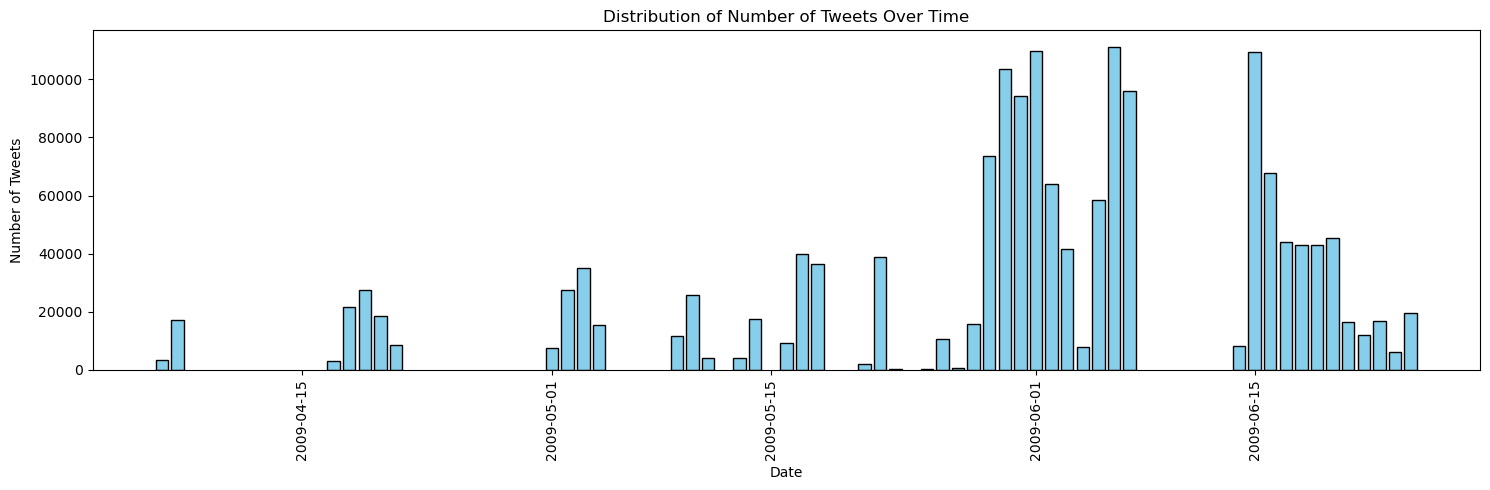

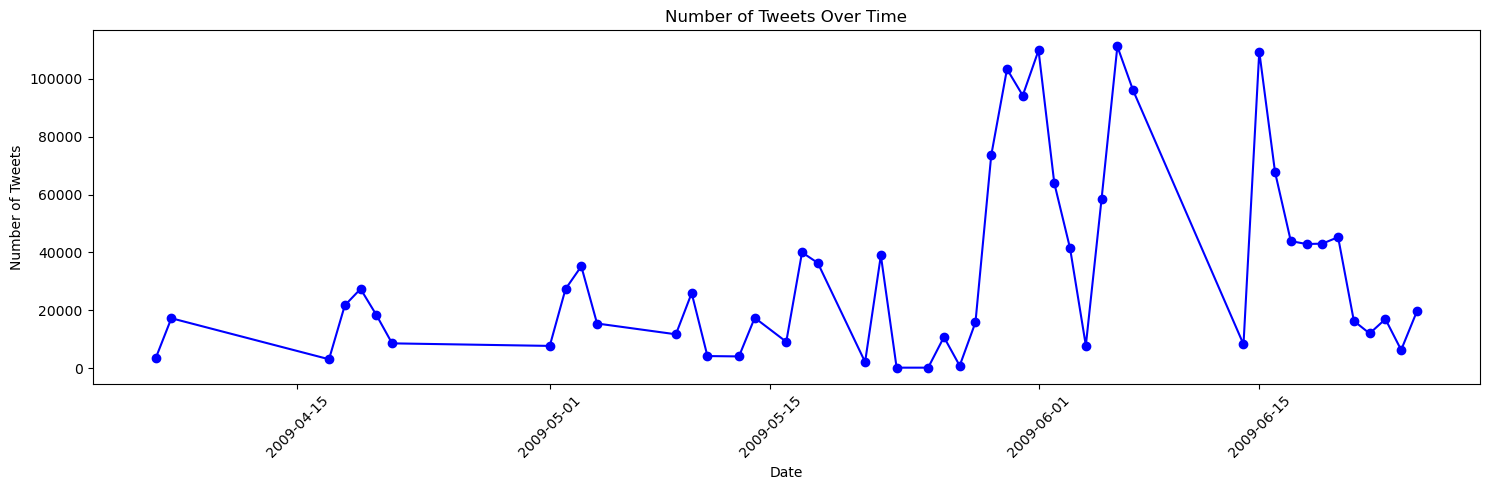

In [24]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
tweets_per_day_pd = tweets_per_day.toPandas()

# Sort the DataFrame based on the date for the line plot
tweets_per_day_pd.sort_values('daily_records', inplace=True)

# Plot the bar chart
plt.figure(figsize=(15, 5))
plt.bar(tweets_per_day_pd['daily_records'], tweets_per_day_pd['count'], color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=90)  # Rotate the dates for better readability if there are many bars
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Line plot of the number of tweets over time
plt.figure(figsize=(15, 5))
plt.plot(tweets_per_day_pd['daily_records'], tweets_per_day_pd['count'], marker='o', linestyle='-', color='blue')
plt.title('Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


- The previous code shows that the number of tweets per day are not equal, presenting high variability between the days recorded (not normally distributed, based on the histogram). 
- Both the plots (bar and line) presents how the volume of tweets changes overtime, where the end of May until the middle of June have the highest number of tweets collected (more than 200K tweets).

Throughout the project it was noticed some gaps between the recorded days. Therefore, the next codes will identify what days are missing the recorded data range.

In [25]:
# Number of rows
num_rows = tweets_per_day.count()

# Number of columns
num_columns = len(tweets_per_day.columns)

# Print out the shape
print(f"The DataFrame shape is: ({num_rows}, {num_columns})")

The DataFrame shape is: (48, 2)


In [26]:
# Find the Minimum and Maximum Dates
min_date = tweets_per_day.agg(F.min("daily_records")).collect()[0][0]
max_date = tweets_per_day.agg(F.max("daily_records")).collect()[0][0]

# Calculate the Date Range
date_range = (max_date - min_date).days

# Print the Date Range
print(f"The range of days is: {date_range} days")

The range of days is: 80 days


# ADD A CODE TO FIND THE START AND THE END.
According to the previous codes:
- The range is from <b>XXXXx to YYYY</b>
- The total recorded days is 80.
- The number of days recorded is 48, thus the total missing days in the range is 32 days.

After identifying the missing days, which will have to imputed in order to perform time-series analysis, however a further EDA will help to decide a better strategy to address this gaps. 

In [27]:
# Add a new column 'text_length' that contains the length of the 'text' column.
df = df.withColumn("text_length", length(df.text))

# Add a new column 'word_count' that contains the number of words in the 'text' column.
df = df.withColumn("word_count", size(split(df.text, "\s+")))

df.select("text_length", "word_count").show()

+-----------+----------+
|text_length|word_count|
+-----------+----------+
|         28|         6|
|        123|        24|
|         29|         7|
|         82|        16|
|         37|        10|
|        119|        24|
|        111|        22|
|         29|         6|
|         57|        13|
|        118|        20|
|         34|         8|
|         91|        16|
|        128|        22|
|         17|         4|
|        124|        23|
|         67|        16|
|         37|         9|
|         60|        10|
|         56|        11|
|        102|        23|
+-----------+----------+
only showing top 20 rows



In [28]:
df.describe(["word_count", "text_length"]).show()

+-------+------------------+-----------------+
|summary|        word_count|      text_length|
+-------+------------------+-----------------+
|  count|           1595102|          1595102|
|   mean|13.599865713916728|  64.165568722251|
| stddev|6.7376460875575335|34.18022357508237|
|    min|                 1|                2|
|    max|                42|              179|
+-------+------------------+-----------------+



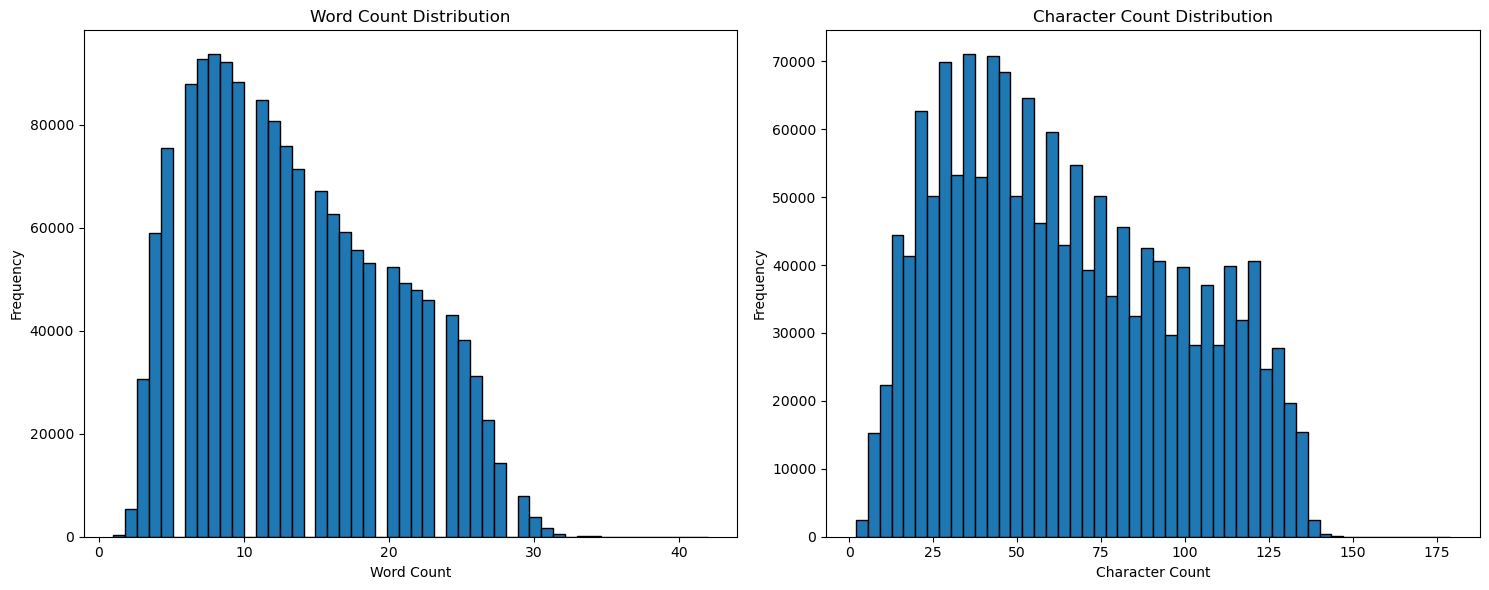

In [29]:
# Selects the word and char count columns
word_char_df = df.select("word_count", "text_length").toPandas()

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Word Count Distribution
axes[0].hist(word_char_df['word_count'], bins=50, edgecolor='black')
axes[0].set_title('Word Count Distribution')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')

# Plot Character Count Distribution
axes[1].hist(word_char_df['text_length'], bins=50, edgecolor='black')
axes[1].set_title('Character Count Distribution')
axes[1].set_xlabel('Character Count')
axes[1].set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [30]:
from pyspark.sql.functions import corr
# Calculates the correlation between the number of words and characters. 
correlation = df.stat.corr("word_count", "text_length")

print(f"The correlation coefficient between word count and character count is: {correlation}")

The correlation coefficient between word count and character count is: 0.9652185064975721


The descripte statistics and histograms of the word and character length informs that:

- Word count:
1. The shortest tweet has 1 word and the longest has 42.
2. The average of words per tweet is 13.6 and the StdDev is 6.75. Thus, with a considerable value in the StdDev, the tweets presents variability, but most of them are clusted around the mean value (average). 
3. The distribution plot shows that the majority of tweets are composed by 20 or less words. 
4. There are also longer tweets but they are less frequent, making the word count slightly right-skewed. 

- Character count: 
1. The shortest tweet has 2 char and the longest has 179. (Not surpassing the maximum amount of characters set by twitter at this time, which is 280).
2. The average of character in each tweet is 64, with a standard deviation of 34. Meaning that the based on the avg value the stddev is high (34), presenting a high variation around the average value. 

- Also the correlation between word and char are very high (0.96), and it is not surprising that if the number of words increases, consequently the text length will also increase.

- With some extreme values noticed in the .describe and the histograms, thus the boxplots will be performed to identify outliers, if there is any. 

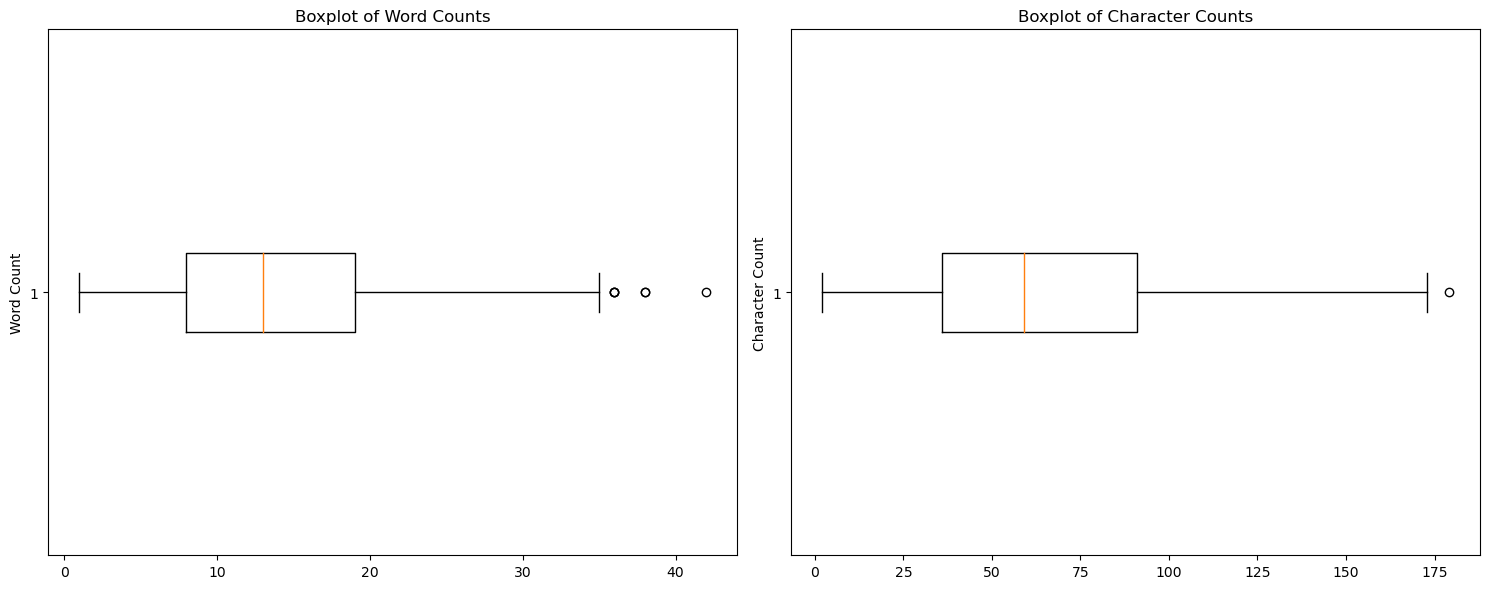

In [31]:
# Creates a figure with two subplots side by side for boxplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Boxplot for Word Count
axes[0].boxplot(word_char_df['word_count'], vert=False)
axes[0].set_title('Boxplot of Word Counts')
axes[0].set_ylabel('Word Count')

# Plot Boxplot for Character Count
axes[1].boxplot(word_char_df['text_length'], vert=False)
axes[1].set_title('Boxplot of Character Counts')
axes[1].set_ylabel('Character Count')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

- The boxplots of the number of character and words indicated the presence of outliers. However, users can express their opinions within a max range of characters, turning the outliers for this project a valid data point for analysis.  

- The next step will perform an aggregation to obtain the daily average of tweets word and characters count.

In [32]:
# Extract the daily records and the word count
daily_word_count = df.groupBy("daily_records") \
    .agg(F.avg("word_count").alias("average_word_count"))

# Show the resulting DataFrame
daily_word_count.show()

+-------------+------------------+
|daily_records|average_word_count|
+-------------+------------------+
|   2009-05-13|13.517385943279901|
|   2009-06-25|14.155266236077912|
|   2009-05-01|13.502405408919516|
|   2009-06-15|13.517517654689799|
|   2009-06-07| 13.37701929987189|
|   2009-05-03|13.527716249219061|
|   2009-06-24|14.069212410501194|
|   2009-05-11|13.657252273815223|
|   2009-05-27|13.224611708482676|
|   2009-04-17|13.540637191157348|
|   2009-06-20|13.933439335718386|
|   2009-04-20|13.646291768541158|
|   2009-06-22|14.025946938094444|
|   2009-04-21| 13.78149790013999|
|   2009-05-23|13.680473372781066|
|   2009-05-25|13.911242603550296|
|   2009-06-01|13.590260331330784|
|   2009-04-19| 13.41344820033584|
|   2009-05-18|13.680515838099428|
|   2009-06-21|13.944080357689716|
+-------------+------------------+
only showing top 20 rows



In [33]:
# Creates a df with the daily average for the char count. 
daily_character_count = df.groupBy("daily_records") \
    .agg(F.avg("text_length").alias("average_character_count")) \
    .orderBy("daily_records")

# Show the resulting DataFrame
daily_character_count.show()

+-------------+-----------------------+
|daily_records|average_character_count|
+-------------+-----------------------+
|   2009-04-06|      64.73397243858598|
|   2009-04-07|      65.22715419829635|
|   2009-04-17|      64.03836150845254|
|   2009-04-18|     63.206554807780954|
|   2009-04-19|      63.39782434109659|
|   2009-04-20|      64.69926650366749|
|   2009-04-21|      65.30121325244984|
|   2009-05-01|     63.832531530360164|
|   2009-05-02|      64.19498556339315|
|   2009-05-03|      63.88851025160447|
|   2009-05-04|      64.22819748606972|
|   2009-05-09|      62.71328492097394|
|   2009-05-10|      64.25258208725143|
|   2009-05-11|      64.36141694590714|
|   2009-05-13|      64.40887792848335|
|   2009-05-14|          65.1201171875|
|   2009-05-16|      62.78132543339917|
|   2009-05-17|      63.61345524494741|
|   2009-05-18|      64.95430048394192|
|   2009-05-21|      63.88024516737388|
+-------------+-----------------------+
only showing top 20 rows



- Also looking at the distribution plot where most of the tweets are allocated between word level (5-15) and char level (50-65), the resulted daily averages falls under the expected range. However, a similiar average was not expected. 

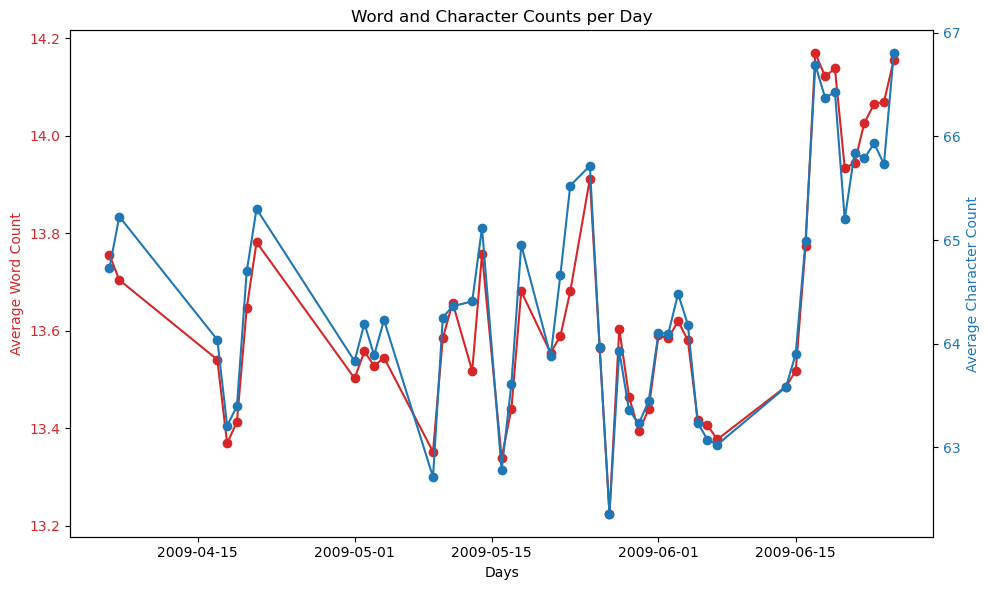

In [34]:
# Convert to Pandas DataFrames
daily_word_count_pd = daily_word_count.toPandas()
daily_character_count_pd = daily_character_count.toPandas()

# Sort Pandas DataFrames by 'daily_records'
daily_word_count_pd = daily_word_count_pd.sort_values('daily_records')
daily_character_count_pd = daily_character_count_pd.sort_values('daily_records')

# Plotting the graph
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('Average Word Count', color=color)
ax1.plot(daily_word_count_pd['daily_records'], daily_word_count_pd['average_word_count'], color=color, marker='o', label='Average Word Count')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Character Count', color=color)
ax2.plot(daily_character_count_pd['daily_records'], daily_character_count_pd['average_character_count'], color=color, marker='o', label='Average Character Count')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Word and Character Counts per Day')
plt.tight_layout()
plt.show()

- The line plot with the word and character count per day follow the logical where the number of characters tend to follow the number of words. 
- Only a few days where user posted longer tweets but with less characters.

# EDA Sentiment Label and Scores

In [37]:
# Calculate the total number of tweets
total_count = df.count()

# Group by the 'sentiment' column and count the occurrences
frequency_df = df.groupBy("sentiment_result").count()

# Show the result
frequency_df.show()

+----------------+------+
|sentiment_result| count|
+----------------+------+
|             pos|828984|
|             neg|680619|
|         neutral| 85499|
+----------------+------+



The next codes will analyse the statistics and distribution of sentiment scores.

In [38]:
# Sentiment scores descriptive statistics.
df.describe("sentiment_score").show()

+-------+-------------------+
|summary|    sentiment_score|
+-------+-------------------+
|  count|            1595102|
|   mean|0.09432671703753073|
| stddev| 0.9291023282179852|
|    min|               -1.0|
|    max|                1.0|
+-------+-------------------+



In [39]:
from pyspark.sql.functions import when
# Defines bin ranges.
bin_ranges = [-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Creates a new column for the bins.
# Creates bin conditions using a function.
bin_conditions = when(df.sentiment_score <= bin_ranges[0], str(bin_ranges[0]))
for i in range(1, len(bin_ranges)):
    bin_conditions = bin_conditions.when((df.sentiment_score > bin_ranges[i - 1]) & (df.sentiment_score <= bin_ranges[i]), str(bin_ranges[i]))

# Adds a default case if needed.
bin_conditions = bin_conditions.otherwise(str(bin_ranges[-1]))

# Apply the binning.
df_with_bins = df.select("sentiment_score").withColumn("score_bin", bin_conditions)

# Group by the bins and the count.
histogram_data = df_with_bins.groupBy("score_bin").count().collect()

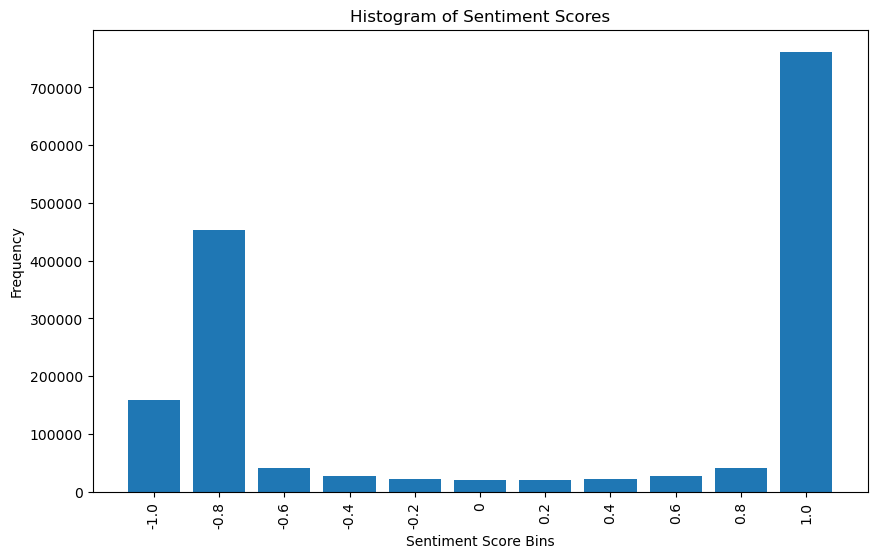

In [40]:
# Convert the score_bin from a range string to the lower bound for sorting
histogram_data_sorted = sorted(histogram_data, key=lambda x: float(x['score_bin'].split(' to ')[0]))

# Now extract the bins and counts again, which should be sorted
bins_sorted = [row['score_bin'] for row in histogram_data_sorted]
counts_sorted = [row['count'] for row in histogram_data_sorted]

# Plot the histogram with the sorted bins
plt.figure(figsize=(10, 6))
plt.bar(range(len(counts_sorted)), counts_sorted, align='center')  # Use numerical x-axis
plt.xticks(range(len(bins_sorted)), bins_sorted, rotation=90)  # Add bin labels as x-tick labels
plt.xlabel('Sentiment Score Bins')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Scores')
plt.show()


The previous codes shows that:
- The range of the scores are between -1 and 1 (as expected from the model).
- The sentiment scores have the average of 0.09, informing that the overall sentiment of the dataframe is slightly positive. 
- The StdDev of 0.929 shows that the scores will present a high variability and based on the range it will vary between the extreme points. 
- Due to its characteristics the distribution do not present any skewness, but rather a big difference between extreme "opinions" and neutral tweets. 
- By investigating the histogram where it shows that most of the values are located at the extremes (Bimodal distribution) and because of the mathematical operation the average will tend to the center.
<br><br><br>

Further analysis will be perform on the daily basis, thus the next step will aggregate to generate the overall sentment of the day. However, the distribution of tweets are unequal among the recorded days. Therefore, different techniques will be attemped to chose the most appropriate to continue.  

In [41]:
# Calculate the median sentiment score for each day
daily_median_sentiment = df.groupBy('daily_records').agg(F.expr('percentile_approx(sentiment_score, 0.5)').alias('median_sentiment'))
daily_median_sentiment.show()

+-------------+----------------+
|daily_records|median_sentiment|
+-------------+----------------+
|   2009-05-13|           0.722|
|   2009-06-25|           -0.71|
|   2009-05-01|           0.757|
|   2009-06-15|           0.716|
|   2009-06-07|           0.827|
|   2009-05-03|           0.754|
|   2009-06-24|          -0.587|
|   2009-05-11|           0.602|
|   2009-05-27|           0.501|
|   2009-04-17|           0.836|
|   2009-06-20|           -0.59|
|   2009-04-20|           0.744|
|   2009-06-22|          -0.561|
|   2009-04-21|           0.751|
|   2009-05-23|           0.785|
|   2009-05-25|           0.943|
|   2009-06-01|           0.734|
|   2009-04-19|           0.802|
|   2009-05-18|           0.771|
|   2009-06-21|          -0.512|
+-------------+----------------+
only showing top 20 rows



In [42]:
# For weighted average, calculate the mean sentiment and count of tweets for each day
daily_sentiment = df.select("sequence", "sentiment_score", "daily_records").groupBy('daily_records').agg(
    F.avg('sentiment_score').alias('average_sentiment'),
    F.count('sequence').alias('tweet_count')
)

# Add a normalized weight for each day based on tweet count
max_tweets = daily_sentiment.agg(F.max('tweet_count')).first()[0]
daily_sentiment = daily_sentiment.withColumn('weight', F.col('tweet_count') / max_tweets)

# Calculate the weighted average sentiment
weighted_average_sentiment = daily_sentiment.withColumn('weighted_sentiment', F.col('weight') * F.col('average_sentiment'))

weighted_average_sentiment.show()

+-------------+--------------------+-----------+--------------------+--------------------+
|daily_records|   average_sentiment|tweet_count|              weight|  weighted_sentiment|
+-------------+--------------------+-----------+--------------------+--------------------+
|   2009-05-13| 0.11017016029593096|       4055| 0.03645337025117316|0.004016073643898668|
|   2009-06-25|-0.11998479377511061|      19663|  0.1767651342167245|-0.02120912817562...|
|   2009-05-01| 0.12626537511376928|       7691| 0.06914004207195383| 0.00872999334759704|
|   2009-06-15| 0.11271443710545312|     109461|  0.9840252431722972|  0.1109138513817221|
|   2009-06-07| 0.14338083136307303|      96011|  0.8631133245833258| 0.12375390603930315|
|   2009-05-03|   0.123260464587948|      35214| 0.31656448336000287| 0.03901988529099769|
|   2009-06-24|-0.09169339697692921|       6285| 0.05650047645588738|-0.00518072061705...|
|   2009-05-11| 0.09446768788894204|       4178| 0.03755910749923587|0.003548122044625...|

In [43]:
# Collect the data to the local environment
daily_median_sentiment_data = daily_median_sentiment.sort('daily_records').collect()

# Extract dates and median sentiments for plotting
dates = [row['daily_records'] for row in daily_median_sentiment_data]
median_sentiments = [row['median_sentiment'] for row in daily_median_sentiment_data]

# Collect the data to the local environment
weighted_average_sentiment_data = weighted_average_sentiment.sort('daily_records').collect()

# Extract dates and weights and averages.
dates = [row['daily_records'] for row in weighted_average_sentiment_data]
weighted_avg_sentiments = [row['weighted_sentiment'] for row in weighted_average_sentiment_data]
avg_sentiments = [row['average_sentiment'] for row in weighted_average_sentiment_data]

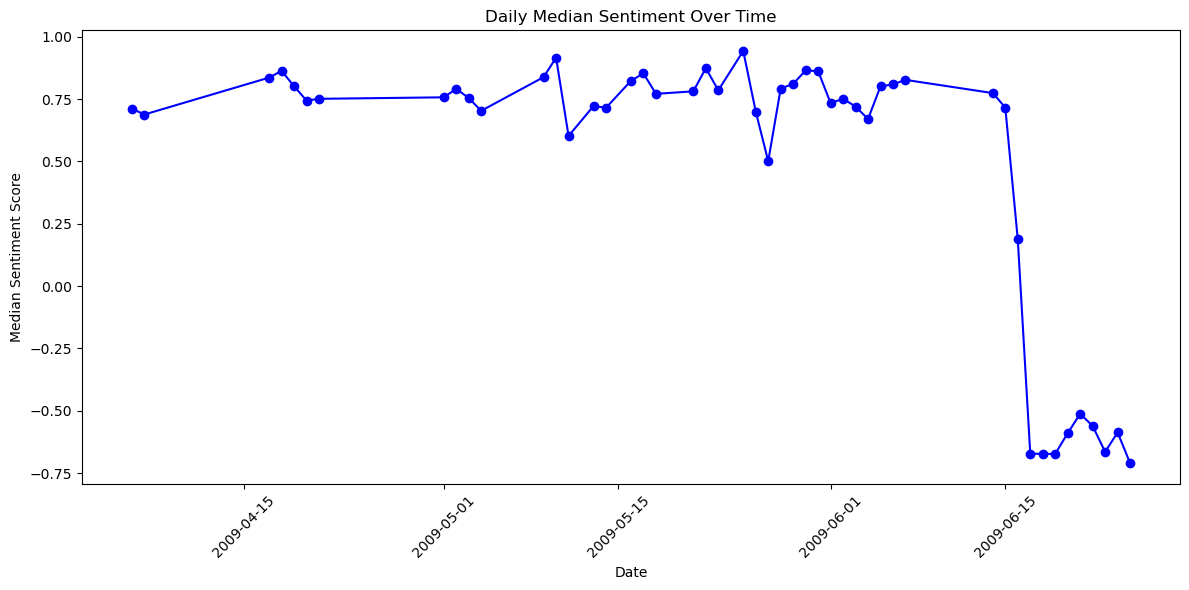

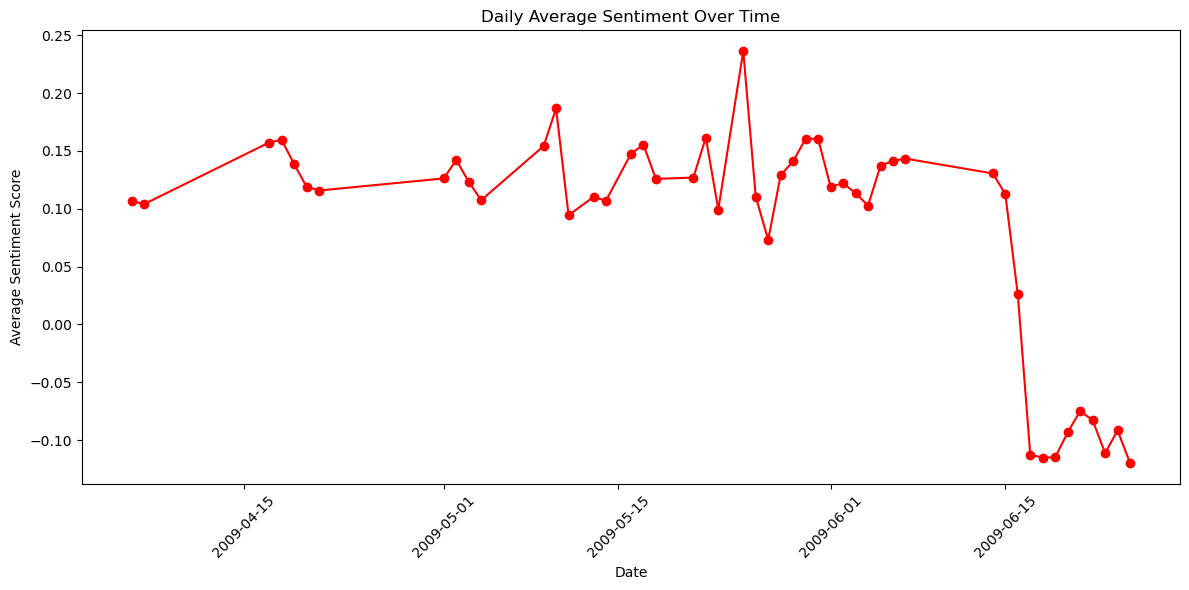

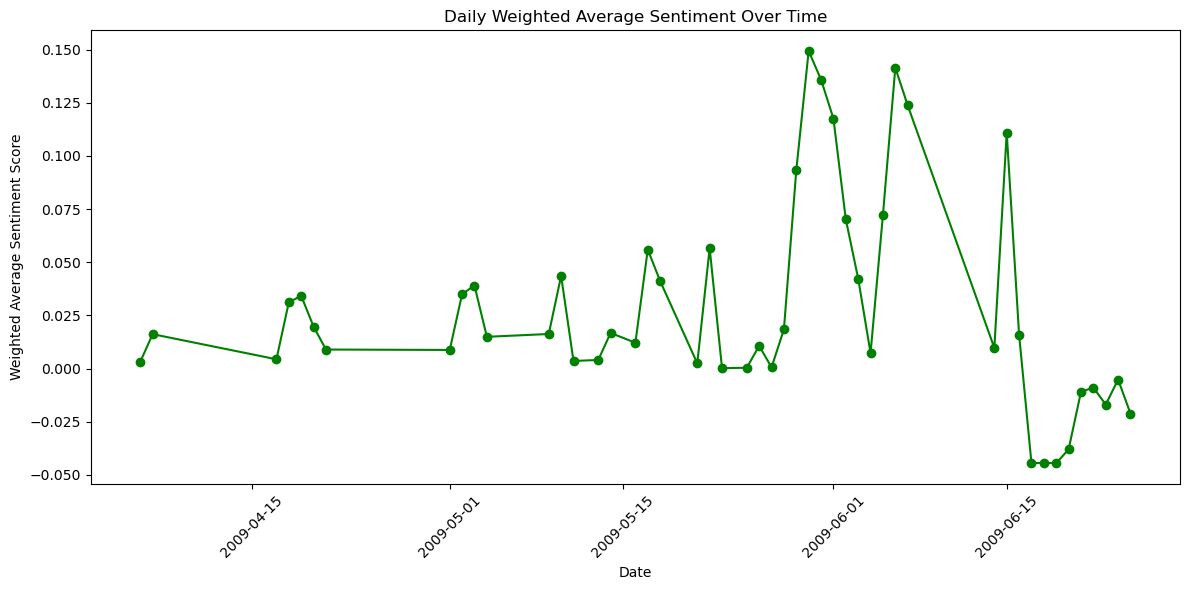

In [44]:
# Now plot the time series
plt.figure(figsize=(12, 6))
plt.plot(dates, median_sentiments, marker='o', linestyle='-', color='blue')
plt.title('Daily Median Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Median Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Now plot the time series
plt.figure(figsize=(12, 6))
plt.plot(dates, avg_sentiments, marker='o', linestyle='-', color='red')
plt.title('Daily Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Now plot the time series
plt.figure(figsize=(12, 6))
plt.plot(dates, weighted_avg_sentiments, marker='o', linestyle='-', color='green')
plt.title('Daily Weighted Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Weighted Average Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

Three techniques applied to obtain the overall sentiment of the day resulted in the following insights.
- By using average or median it yielded a similar pattern, although having different representation scales. 
- By using weighted average it presented a different format, taking in to account the weights based on the volume of tweets posted per day.

The chosen approach to aggregate the daily sentiment score will be performed using the weighted average: 
- More data available on these days, presenting not only more samples, but with different scale of moods and polarities. 
- Days with few tweets (hundreds), can have numerous extreme scores which can lead to skewness. But days with more tweets (+200K) may represent a day  that something important was happening that day.

The chosen approach has a direct affect on the shape, which will be strongly correlated to the volume of tweets as observed in the following plot.

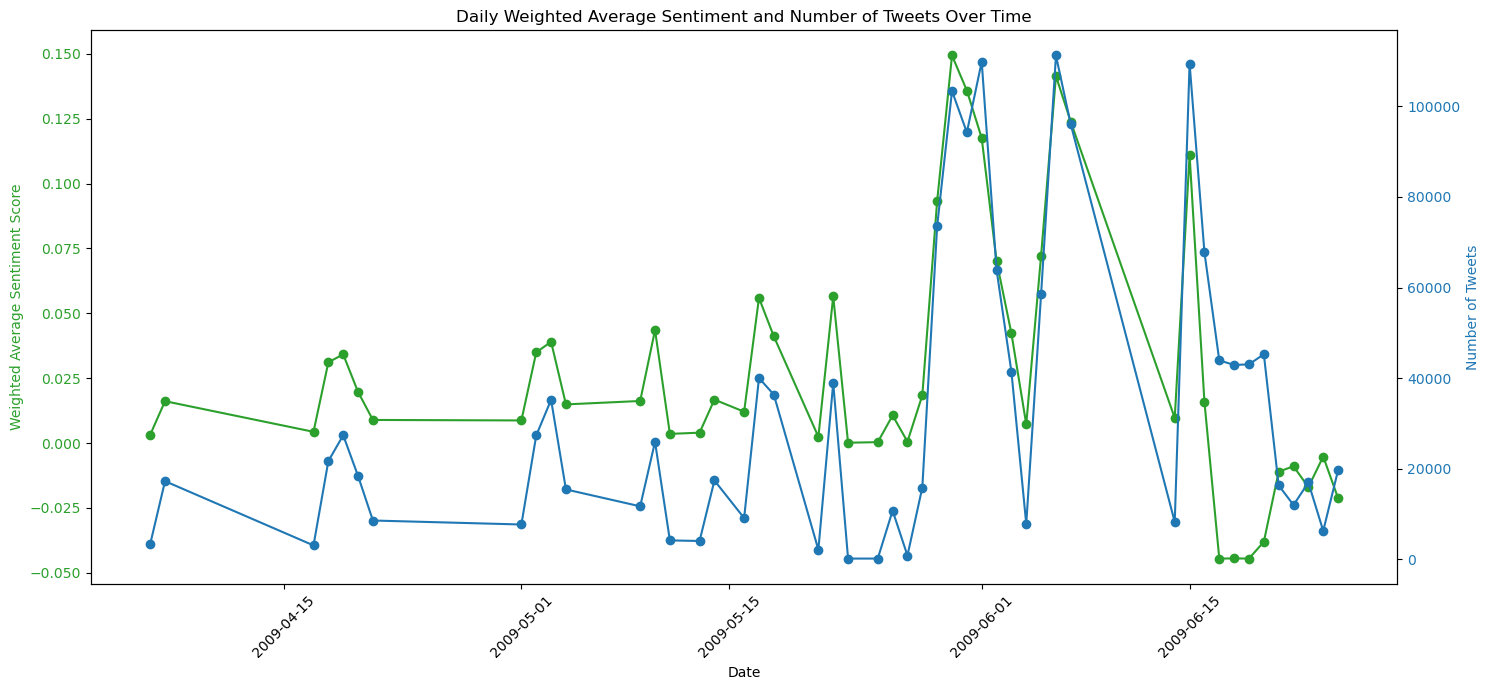

In [45]:
# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot the weighted average sentiment over time on the primary y-axis
color = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('Weighted Average Sentiment Score', color=color)
ax1.plot(dates, weighted_avg_sentiments, marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

# Instantiate a second y-axis, sharing the same x-axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Number of Tweets', color=color)  
ax2.plot(tweets_per_day_pd['daily_records'], tweets_per_day_pd['count'], marker='o', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Daily Weighted Average Sentiment and Number of Tweets Over Time')
fig.tight_layout()  # Adjust the plot to ensure everything fits without overlapping

plt.show()

- As mentioned earlier, but also by the characteristics of the technique, most of the sentiment scores tend to follow the volume of the tweets. 

The dataframe to be used in the time seties analysis contains the date of the record (daily_records), the weight (based on volume of tweets) and the the weighted sentiment score. 

### Time-Series Analysis using daily overall sentiment score. 

The analysis will be carried out using the days as the time points and the weighted sentiment. 

In [46]:
# Drops the columns that are no longer needed for the next stages.
df_daily_sent = weighted_average_sentiment.drop("average_sentiment", "tweet_count")

# Reducing the precision to 3 and 5 decimals can keep the precision and at the same making the column 
# more memory friendly.
df_daily_sent = df_daily_sent.withColumn("weighted_sentiment", round(df_daily_sent["weighted_sentiment"], 3))
df_daily_sent = df_daily_sent.withColumn("weight", round(df_daily_sent["weight"], 5))
df_daily_sent.show()

+-------------+-------+------------------+
|daily_records| weight|weighted_sentiment|
+-------------+-------+------------------+
|   2009-05-13|0.03645|             0.004|
|   2009-06-25|0.17677|            -0.021|
|   2009-05-01|0.06914|             0.009|
|   2009-06-15|0.98403|             0.111|
|   2009-06-07|0.86311|             0.124|
|   2009-05-03|0.31656|             0.039|
|   2009-06-24| 0.0565|            -0.005|
|   2009-05-11|0.03756|             0.004|
|   2009-05-27|0.00752|             0.001|
|   2009-04-17|0.02765|             0.004|
|   2009-06-20|0.40707|            -0.038|
|   2009-04-20|0.16546|              0.02|
|   2009-06-22|0.10775|            -0.009|
|   2009-04-21|0.07706|             0.009|
|   2009-05-23|0.00152|               0.0|
|   2009-05-25|0.00152|               0.0|
|   2009-06-01|0.98761|             0.118|
|   2009-04-19|0.24626|             0.034|
|   2009-05-18|0.32694|             0.041|
|   2009-06-21|0.14678|            -0.011|
+----------

In [47]:
# Calculate the minimum and maximum dates using fully qualified function names
min_max_dates = df_daily_sent.agg(F.min("daily_records").alias("start_date"), 
                       F.max("daily_records").alias("end_date")).collect()
start_date, end_date = min_max_dates[0]['start_date'], min_max_dates[0]['end_date']

# Print the start and end dates
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")

Start Date: 2009-04-06
End Date: 2009-06-25


- The data ranges from 06-04-2009 to 25-06-2009

With gaps identified in early stages, the following codes will add the missing days so the imputation of sentiment scores can be performed. 

In [48]:
from pyspark.sql.functions import explode, sequence, to_date, lit

# Create a DataFrame with a range of dates
date_df = spark.sql("SELECT explode(sequence(to_date('2009-04-06'), to_date('2009-06-25'), interval 1 day)) as daily_records")
date_df.show()

+-------------+
|daily_records|
+-------------+
|   2009-04-06|
|   2009-04-07|
|   2009-04-08|
|   2009-04-09|
|   2009-04-10|
|   2009-04-11|
|   2009-04-12|
|   2009-04-13|
|   2009-04-14|
|   2009-04-15|
|   2009-04-16|
|   2009-04-17|
|   2009-04-18|
|   2009-04-19|
|   2009-04-20|
|   2009-04-21|
|   2009-04-22|
|   2009-04-23|
|   2009-04-24|
|   2009-04-25|
+-------------+
only showing top 20 rows



In [49]:
# Join with the existing DataFrame
result_df = date_df.join(df_daily_sent, "daily_records", "left_outer")

# Show the result
result_df.show()

+-------------+-------+------------------+
|daily_records| weight|weighted_sentiment|
+-------------+-------+------------------+
|   2009-04-11|   null|              null|
|   2009-04-17|0.02765|             0.004|
|   2009-04-20|0.16546|              0.02|
|   2009-04-15|   null|              null|
|   2009-04-16|   null|              null|
|   2009-04-13|   null|              null|
|   2009-04-21|0.07706|             0.009|
|   2009-04-19|0.24626|             0.034|
|   2009-04-25|   null|              null|
|   2009-04-14|   null|              null|
|   2009-04-26|   null|              null|
|   2009-04-07|0.15514|             0.016|
|   2009-04-08|   null|              null|
|   2009-04-18|0.19502|             0.031|
|   2009-04-22|   null|              null|
|   2009-04-24|   null|              null|
|   2009-04-06|0.03001|             0.003|
|   2009-04-12|   null|              null|
|   2009-04-23|   null|              null|
|   2009-04-09|   null|              null|
+----------

In [50]:
# Find the count of missing values in the 'text' column
missing_values_count = result_df.filter(result_df.weighted_sentiment.isNull()).count()
print(f"Number of missing values in 'text' column: {missing_values_count}")

Number of missing values in 'text' column: 33


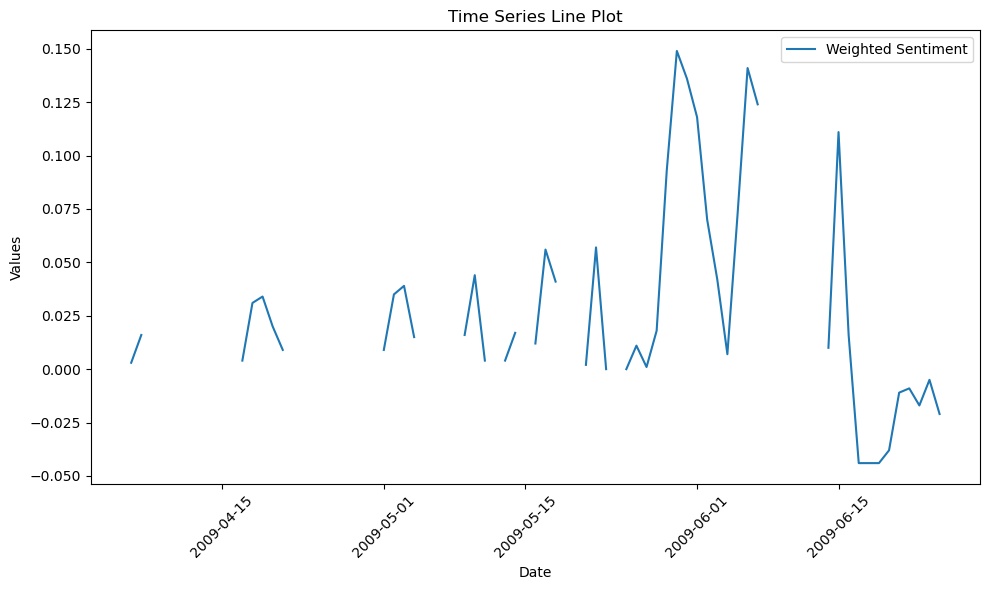

In [52]:
# Order the DataFrame by date
result_df = result_df.orderBy("daily_records")

# Convert to Pandas DataFrame for plotting
pandas_df = result_df.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(pandas_df['daily_records'], pandas_df['weighted_sentiment'], label='Weighted Sentiment')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series Line Plot')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The previous code displayed the line plot showing the gaps in the dataframe:
- There are more missing data at the start of the period. 
- The plot is important to have as a reference to check the perfomance of the techniques applied. 

- The dataframe became much smaller compared to the original set 1.6 million to 81 observations, thus Pandas format will be used also for visualization purpose.

In [53]:
# Reset the index to the date column
pandas_df.reset_index(inplace=True)

# Creating a copy to use as reference.
df_og = result_df.toPandas()

In order to perform time series analysis all the data points in the range has to be filled with score sentiment, therefore imputation approaches will be called in the following cells. 
- The visual results of the imputation (Line plots with the imputed data) will be displayed all together after the coding part.  

#### Linear Interpolation.

As observed in the next code and lineplot, it presented the expected results based on the mathematical features of the approach. Other techniques will be applied to compare the performance and consenquently to chose the best one. 

In [54]:
# Applying cubic interpolation
pandas_df['weighted_sentiment_linear_interp'] = pandas_df['weighted_sentiment'].interpolate(method='linear')

#### Exponential Moving Average (EMA).

1. A technique that uses the value of alpha to help smooth short term functuations, which the can be observed in the scores overtime. 

2. To avoid numerous figures and cells with the same code, only one EMA code is going to be displayed.

In [90]:
# Creating a copy to use for EMA
pandas_df2 = result_df.toPandas()

def ema_imputation(series, alpha):
    imputed_series = series.copy()
    missing_indices = series.isnull()

    for i in range(len(series)):
        if i == 0:
            if missing_indices[i]:
                # Handle first element if it's missing
                imputed_series[i] = 0  # or some other default value
        else:
            if missing_indices[i]:
                # Use EMA formula to impute missing values
                imputed_series[i] = (1 - alpha) * imputed_series[i - 1]
            else:
                # If not missing, keep the original value
                imputed_series[i] = series[i]

    return imputed_series

In [91]:
# Choose the alpha value (smoothing factor)
alpha = 0.5 

# Apply EMA imputation to the 'weighted_sentiment' column
pandas_df2['imputed_weighted_sentiment'] = ema_imputation(pandas_df2['weighted_sentiment'], alpha)

- Alpha values tested: ranges from 0.1 to 1, however all the figures resulted in the same characteristics as observerd in the next figure.

- To apply the rolling weighted average the weights have to be filled, thus the median approach will be selected to perform this.
- The mean The mean provided a higher value (aprox 0.29), thus not giving too much weight to the imputed values (next stage).

In [69]:
# Creating a copy to use for Rolling Weighted Average.
pandas_df3 = result_df.toPandas() 

In [70]:
# Calculate the median of the weights
median_weight = pandas_df3['weight'].median()

# Impute missing weights with the median
pandas_df3['weight'] = pandas_df3['weight'].fillna(median_weight)

In [71]:
# Define the rolling window size
window_size = 10  # set to 10 to fill all the missing days. 

# Compute the weighted sum and the sum of weights for the rolling window
rolling_weighted_sum = pandas_df3['weighted_sentiment'].mul(pandas_df3['weight']).rolling(window=window_size, min_periods=1).sum()
rolling_weight_sum = pandas_df3['weight'].rolling(window=window_size, min_periods=1).sum()

# Calculate the rolling weighted average
rolling_weighted_avg = rolling_weighted_sum / rolling_weight_sum

# Replace NaN values in 'weighted_sentiment' with the rolling weighted average
pandas_df3['imputed_weighted_sentiment'] = pandas_df3['weighted_sentiment'].fillna(rolling_weighted_avg)

pandas_df3.head(20)


,daily_records,weight,weighted_sentiment,imputed_weighted_sentiment
0,2009-04-06,0.030010,0.003,0.003000
1,2009-04-07,0.155140,0.016,0.016000
2,2009-04-08,0.171115,NaN,0.007220
3,2009-04-09,0.171115,NaN,0.004877
4,2009-04-10,0.171115,NaN,0.003683
5,2009-04-11,0.171115,NaN,0.002958
6,2009-04-12,0.171115,NaN,0.002472
7,2009-04-13,0.171115,NaN,0.002123
8,2009-04-14,0.171115,NaN,0.001860
9,2009-04-15,0.171115,NaN,0.001655


In [72]:
# Creating a copy to use for Rolling Weighted Average.
pandas_df1 = result_df.toPandas() 

In [73]:
# Applying cubic interpolation
pandas_df1['weighted_sentiment_cubic_interp'] = pandas_df1['weighted_sentiment'].interpolate(method='cubic')

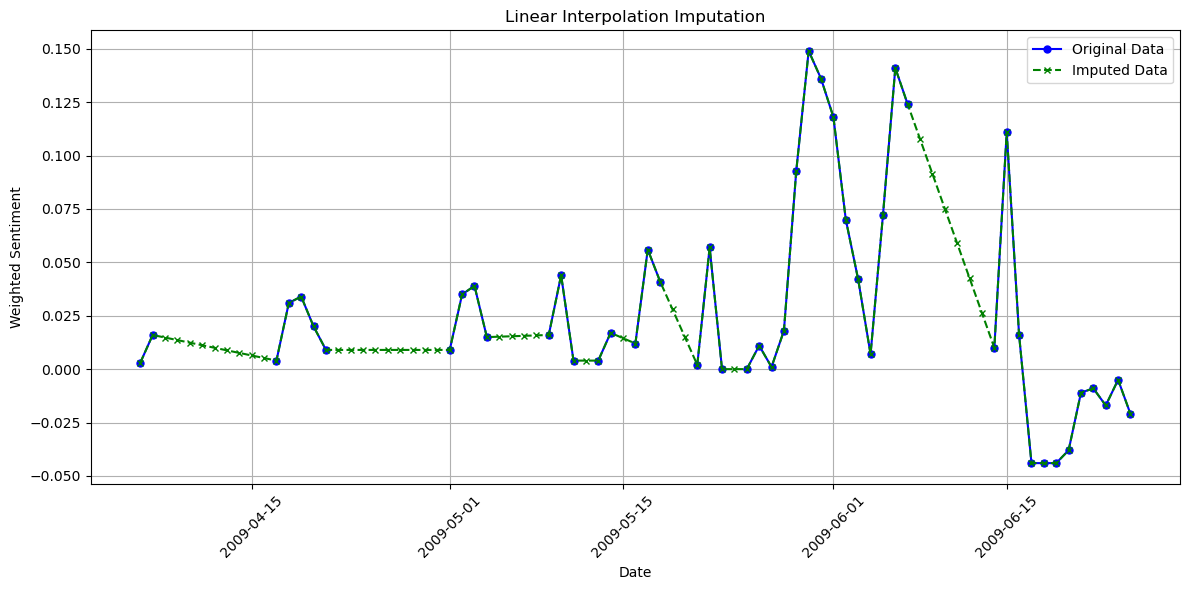

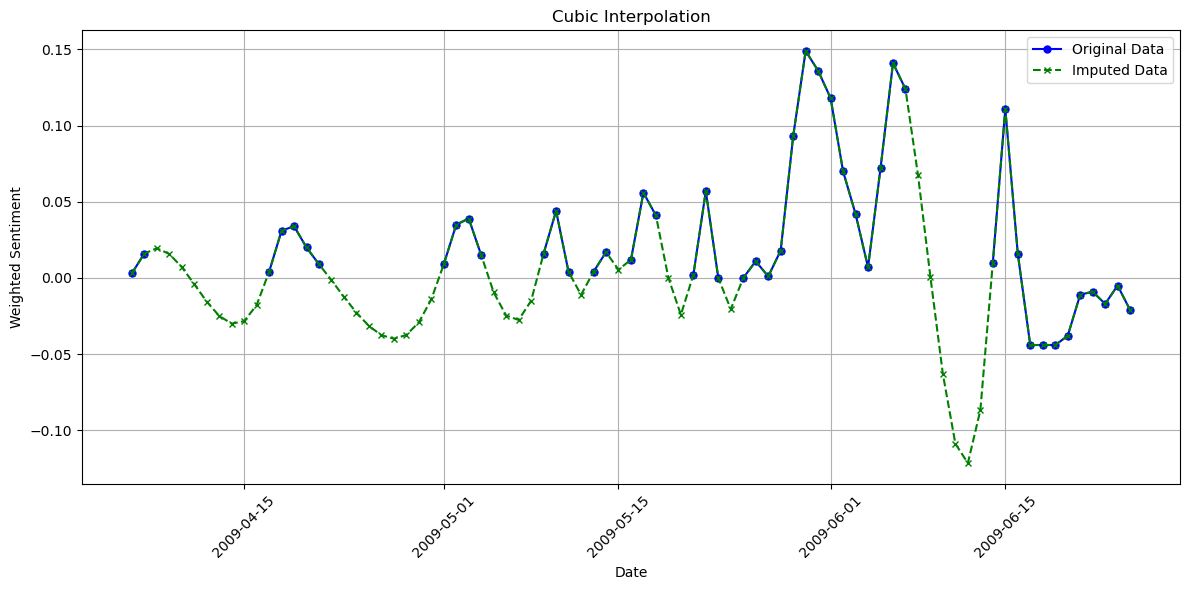

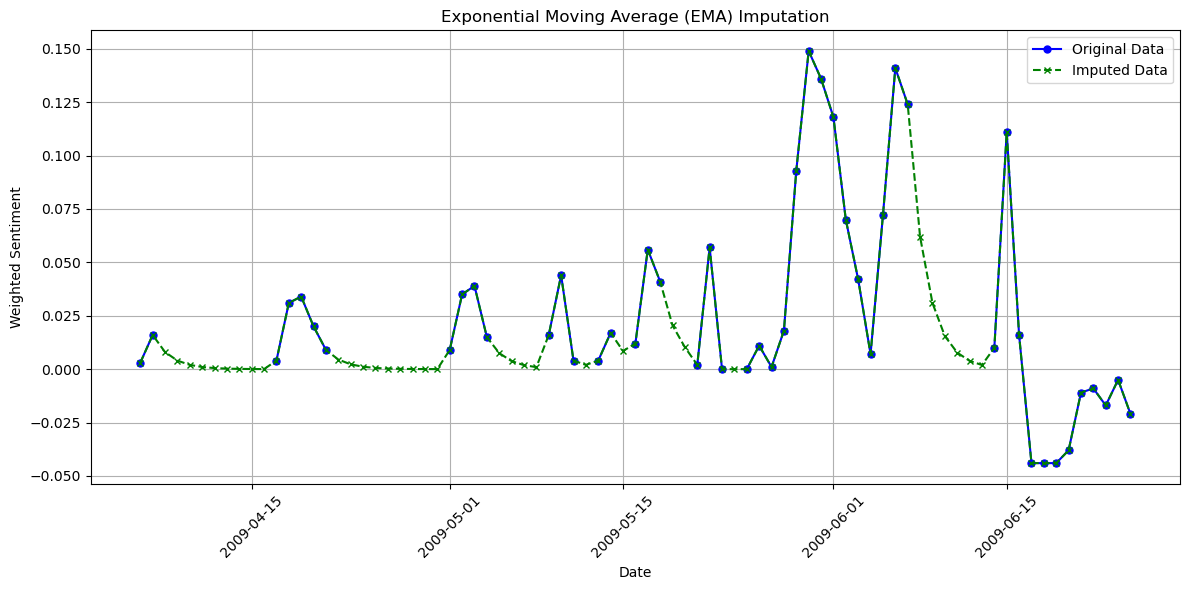

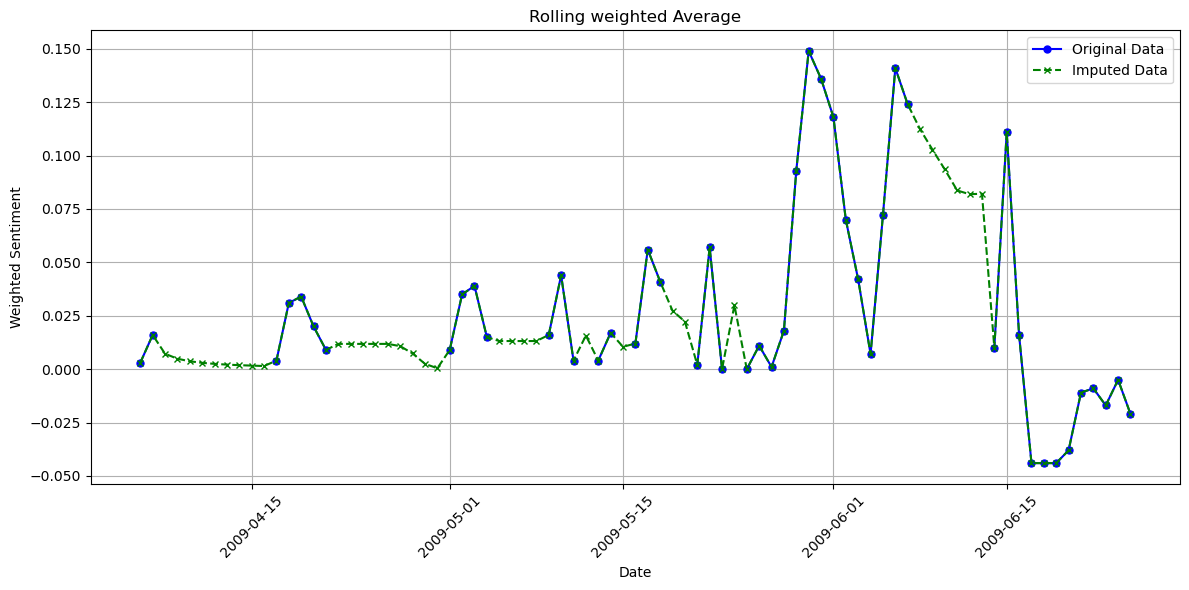

In [92]:
# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(df_og['daily_records'], df_og['weighted_sentiment'], label='Original Data', marker='o', markersize=5, color='blue')
plt.plot(pandas_df['daily_records'], pandas_df['weighted_sentiment_linear_interp'], label='Imputed Data', linestyle='--', marker='x', markersize=5, color='green')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Linear Interpolation Imputation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(df_og['daily_records'], df_og['weighted_sentiment'], label='Original Data', marker='o', markersize=5, color='blue')
plt.plot(pandas_df1['daily_records'], pandas_df1['weighted_sentiment_cubic_interp'], label='Imputed Data', linestyle='--', marker='x', markersize=5, color='green')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Cubic Interpolation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(df_og['daily_records'], df_og['weighted_sentiment'], label='Original Data', marker='o', markersize=5, color='blue')
plt.plot(pandas_df2['daily_records'], pandas_df2['imputed_weighted_sentiment'], label='Imputed Data', linestyle='--', marker='x', markersize=5, color='green')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Exponential Moving Average (EMA) Imputation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(df_og['daily_records'], df_og['weighted_sentiment'], label='Original Data', marker='o', markersize=5, color='blue')
plt.plot(pandas_df3['daily_records'], pandas_df3['imputed_weighted_sentiment'], label='Imputed Data', linestyle='--', marker='x', markersize=5, color='green')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Rolling weighted Average')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [94]:
# Assuming you have four Pandas DataFrames: df1, df2, df3, df4

# Apply .describe() to each DataFrame
description_df1 = pandas_df['weighted_sentiment_linear_interp'].describe()
description_df2 = pandas_df1['weighted_sentiment_cubic_interp'].describe()
description_df3 = pandas_df2['imputed_weighted_sentiment'].describe()
description_df4 = pandas_df3['imputed_weighted_sentiment'].describe()

# Now you can print or further analyze these descriptions
print("Description of sentiment score with linear imputation:\n", description_df1)
print("\nDescription of sentiment score with cubic imputation:\n", description_df2)
print("\nDescription of sentiment score with EMA imputation:\n", description_df3)
print("\nDescription of sentiment score with rolling weighted avg imputation:\n", description_df4)


Description of sentiment score with linear imputation:
 count    81.000000
mean      0.025315
std       0.040619
min      -0.044000
25%       0.006400
50%       0.012400
75%       0.035000
max       0.149000
Name: weighted_sentiment_linear_interp, dtype: float64

Description of sentiment score with cubic imputation:
 count    81.000000
mean      0.007543
std       0.050007
min      -0.121514
25%      -0.021000
50%       0.002000
75%       0.019489
max       0.149000
Name: weighted_sentiment_cubic_interp, dtype: float64

Description of sentiment score with EMA imputation:
 count    81.000000
mean      0.019214
std       0.039437
min      -0.044000
25%       0.000281
50%       0.004500
75%       0.020500
max       0.149000
Name: imputed_weighted_sentiment, dtype: float64

Description of sentiment score with rolling weighted avg imputation:
 count    81.000000
mean      0.026879
std       0.042787
min      -0.044000
25%       0.002958
50%       0.011826
75%       0.039000
max       0.1490

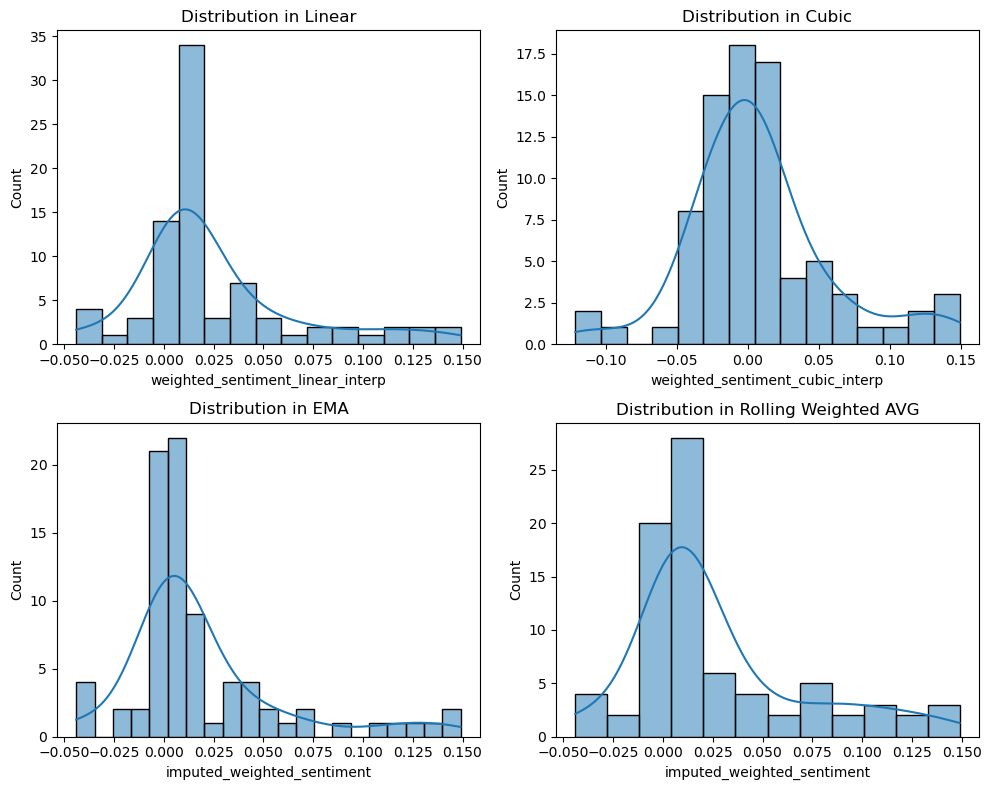

In [98]:
import seaborn as sns

plt.figure(figsize=(10, 8))  # Set the size of the overall figure

# Plot for DataFrame 1
plt.subplot(2, 2, 1)  # Row 1, Column 1
sns.histplot(pandas_df['weighted_sentiment_linear_interp'], kde=True)
plt.title('Distribution in Linear')

# Plot for DataFrame 2
plt.subplot(2, 2, 2)  # Row 1, Column 2
sns.histplot(pandas_df1['weighted_sentiment_cubic_interp'], kde=True)
plt.title('Distribution in Cubic')

# Plot for DataFrame 3
plt.subplot(2, 2, 3)  # Row 2, Column 1
sns.histplot(pandas_df2['imputed_weighted_sentiment'], kde=True)
plt.title('Distribution in EMA')

# Plot for DataFrame 4
plt.subplot(2, 2, 4)  # Row 2, Column 2
sns.histplot(pandas_df3['imputed_weighted_sentiment'], kde=True)
plt.title('Distribution in Rolling Weighted AVG')

plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()  # Display the plots


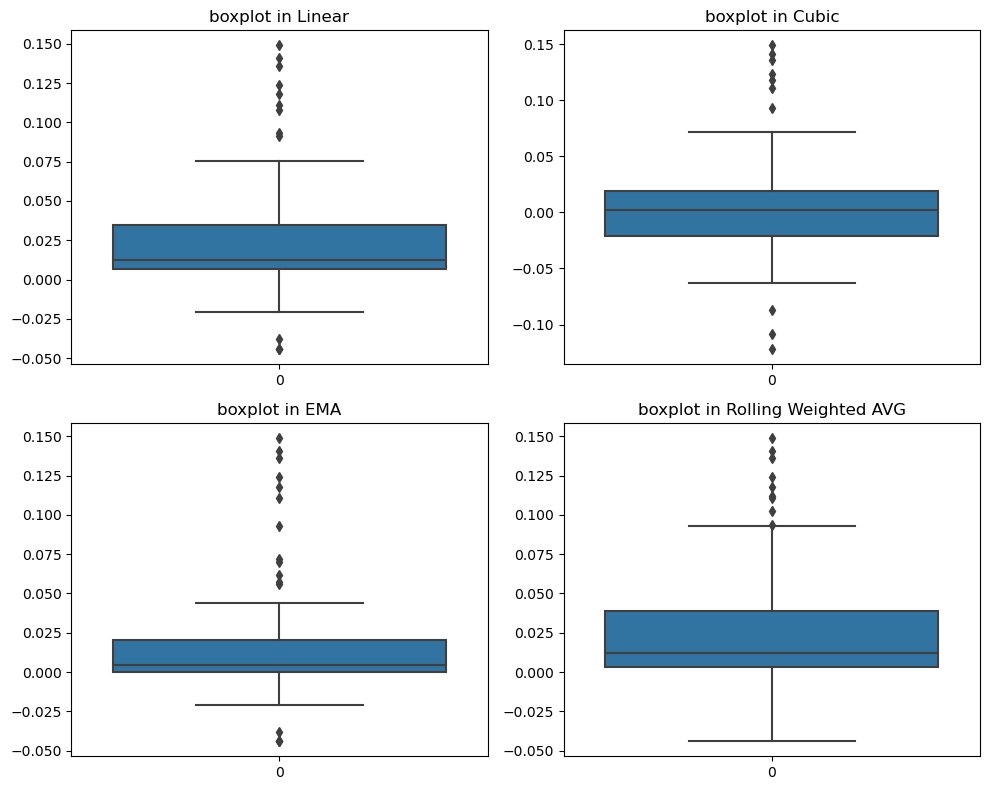

In [100]:
plt.figure(figsize=(10, 8))  # Set the size of the overall figure

# Plot for DataFrame 1
plt.subplot(2, 2, 1)  # Row 1, Column 1
sns.boxplot(pandas_df['weighted_sentiment_linear_interp'])
plt.title('boxplot in Linear')

# Plot for DataFrame 2
plt.subplot(2, 2, 2)  # Row 1, Column 2
sns.boxplot(pandas_df1['weighted_sentiment_cubic_interp'])
plt.title('boxplot in Cubic')

# Plot for DataFrame 3
plt.subplot(2, 2, 3)  # Row 2, Column 1
sns.boxplot(pandas_df2['imputed_weighted_sentiment'])
plt.title('boxplot in EMA')

# Plot for DataFrame 4
plt.subplot(2, 2, 4)  # Row 2, Column 2
sns.boxplot(pandas_df3['imputed_weighted_sentiment'])
plt.title('boxplot in Rolling Weighted AVG')

plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()  # Display the plots

In [111]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
# Applying the transformation directly on the reshaped data
pandas_df['robust_sentiments'] = scaler.fit_transform(pandas_df['weighted_sentiment_linear_interp'].values.reshape(-1, 1))
pandas_df1['robust_sentiments'] = scaler.fit_transform(pandas_df1['weighted_sentiment_cubic_interp'].values.reshape(-1, 1))
pandas_df2['robust_sentiments'] = scaler.fit_transform(pandas_df2['imputed_weighted_sentiment'].values.reshape(-1, 1))
pandas_df3['robust_sentiments'] = scaler.fit_transform(pandas_df3['imputed_weighted_sentiment'].values.reshape(-1, 1))

In [113]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer(method='yeo-johnson')
# Applying the transformation directly on the reshaped data
pandas_df['power_sentiments'] = scaler.fit_transform(pandas_df['weighted_sentiment_linear_interp'].values.reshape(-1, 1))
pandas_df1['power_sentiments'] = scaler.fit_transform(pandas_df1['weighted_sentiment_cubic_interp'].values.reshape(-1, 1))
pandas_df2['power_sentiments'] = scaler.fit_transform(pandas_df2['imputed_weighted_sentiment'].values.reshape(-1, 1))
pandas_df3['power_sentiments'] = scaler.fit_transform(pandas_df3['imputed_weighted_sentiment'].values.reshape(-1, 1))

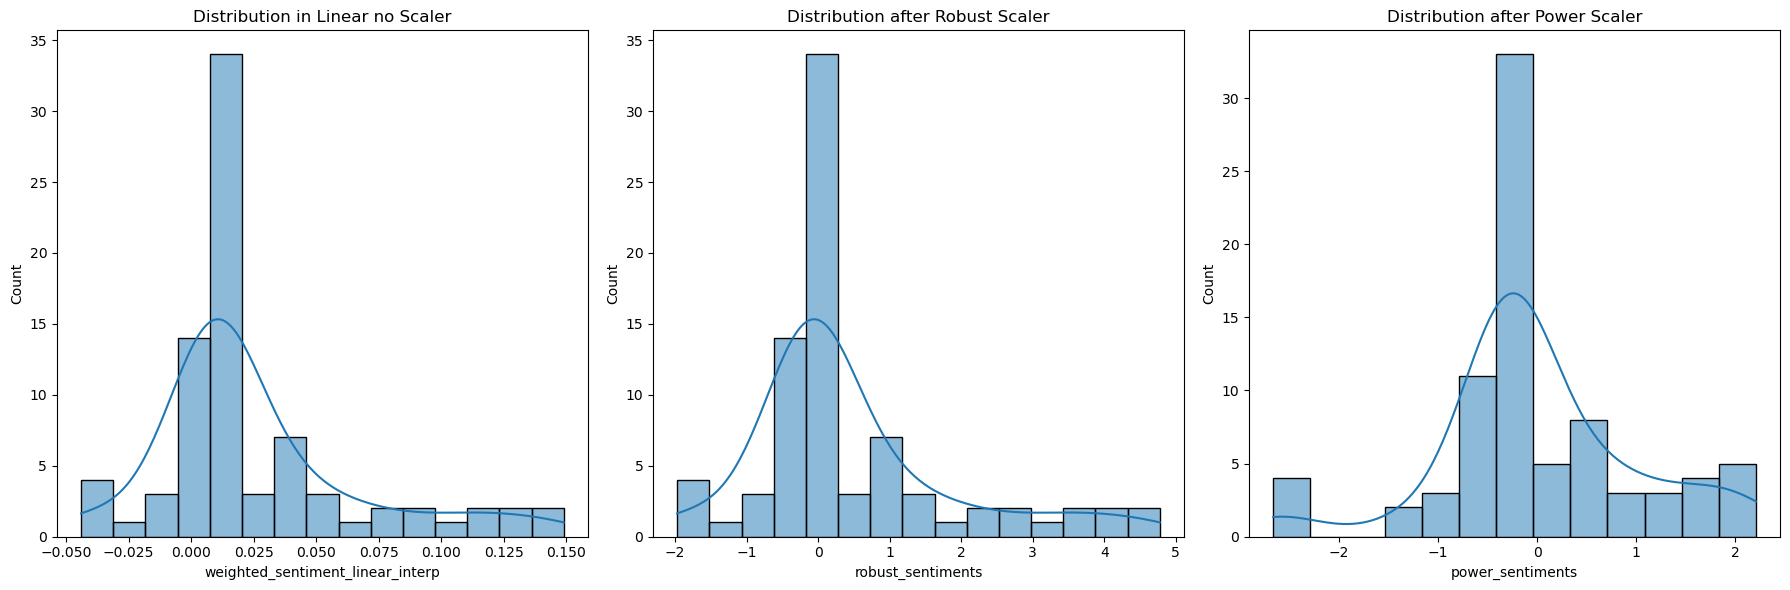

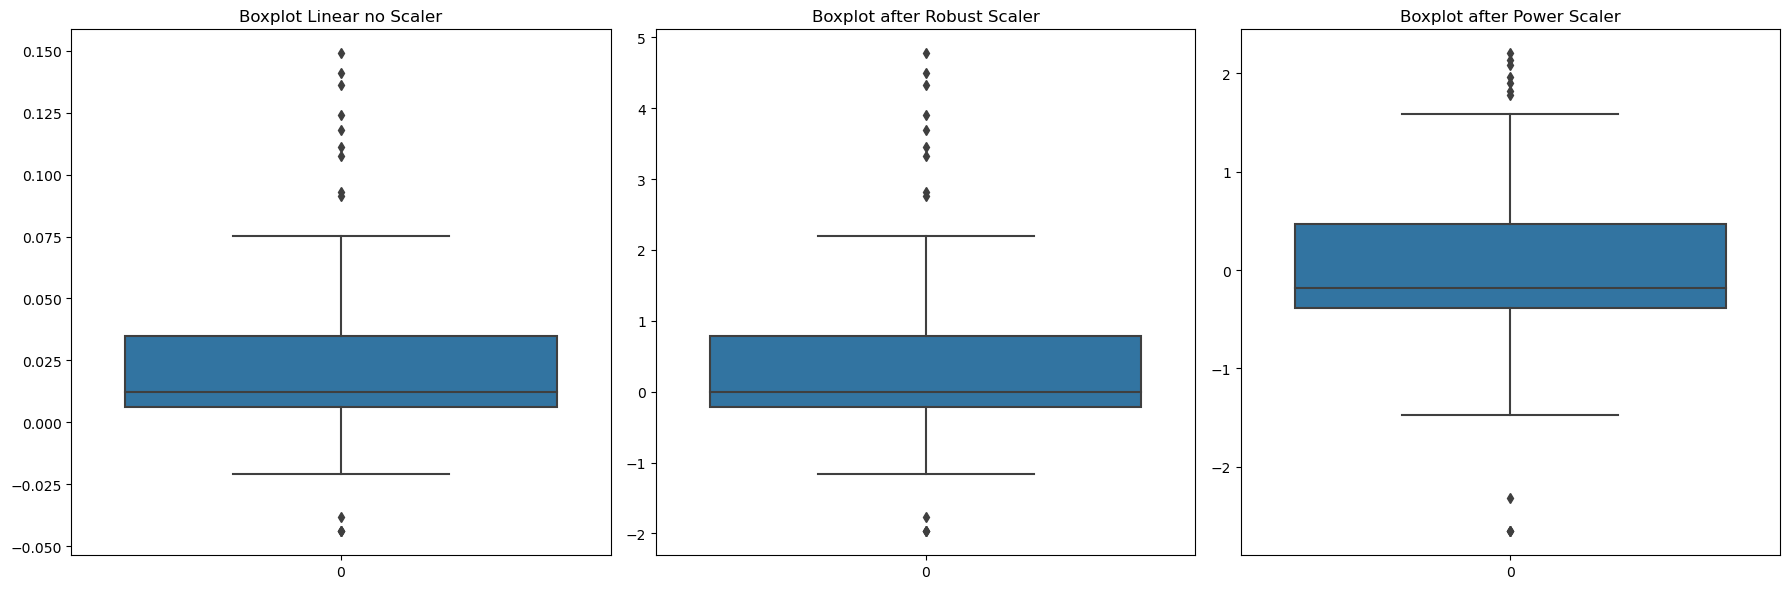

In [124]:
# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.histplot(pandas_df['weighted_sentiment_linear_interp'], kde=True)
plt.title('Distribution in Linear no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.histplot(pandas_df['robust_sentiments'], kde=True)
plt.title('Distribution after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.histplot(pandas_df['power_sentiments'], kde=True)
plt.title('Distribution after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.boxplot(pandas_df['weighted_sentiment_linear_interp'])
plt.title('Boxplot Linear no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.boxplot(pandas_df['robust_sentiments'])
plt.title('Boxplot after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.boxplot(pandas_df['power_sentiments'])
plt.title('Boxplot after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

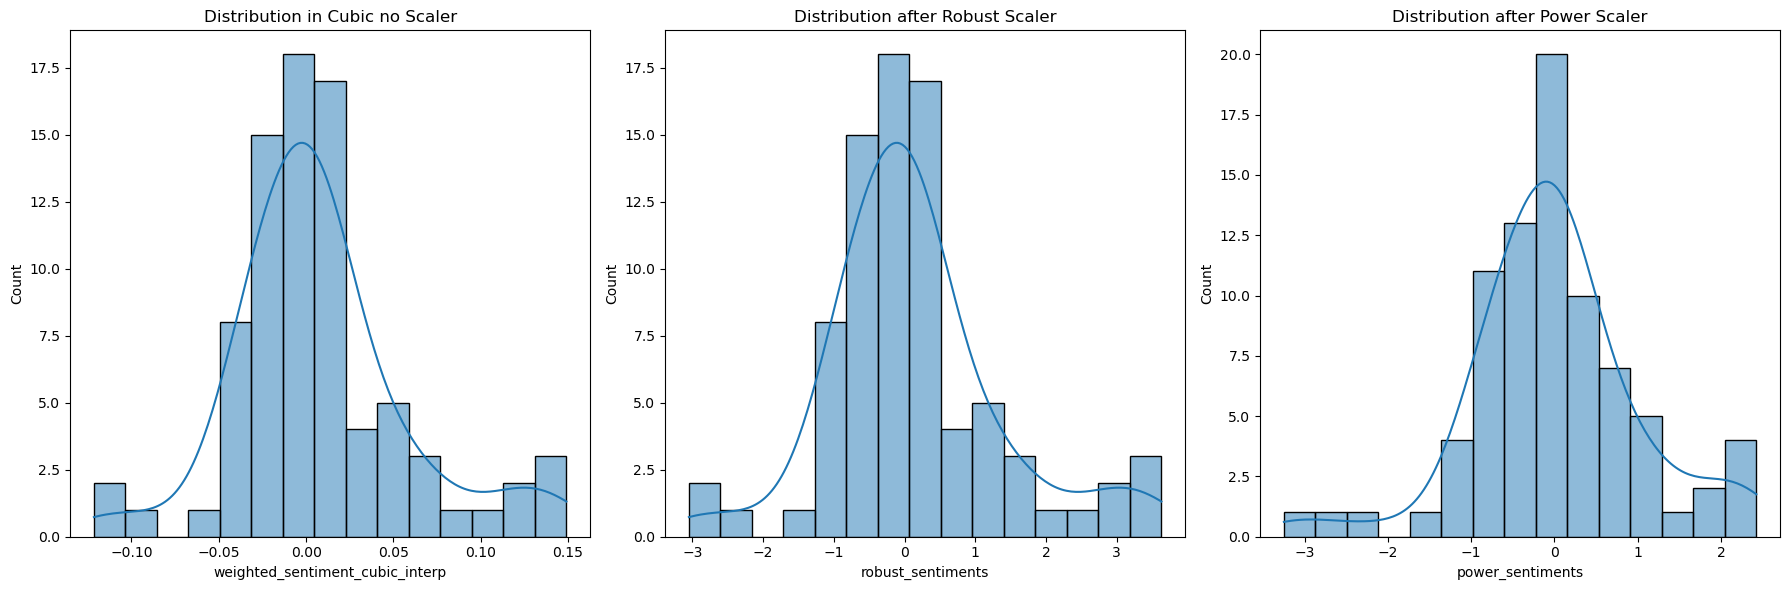

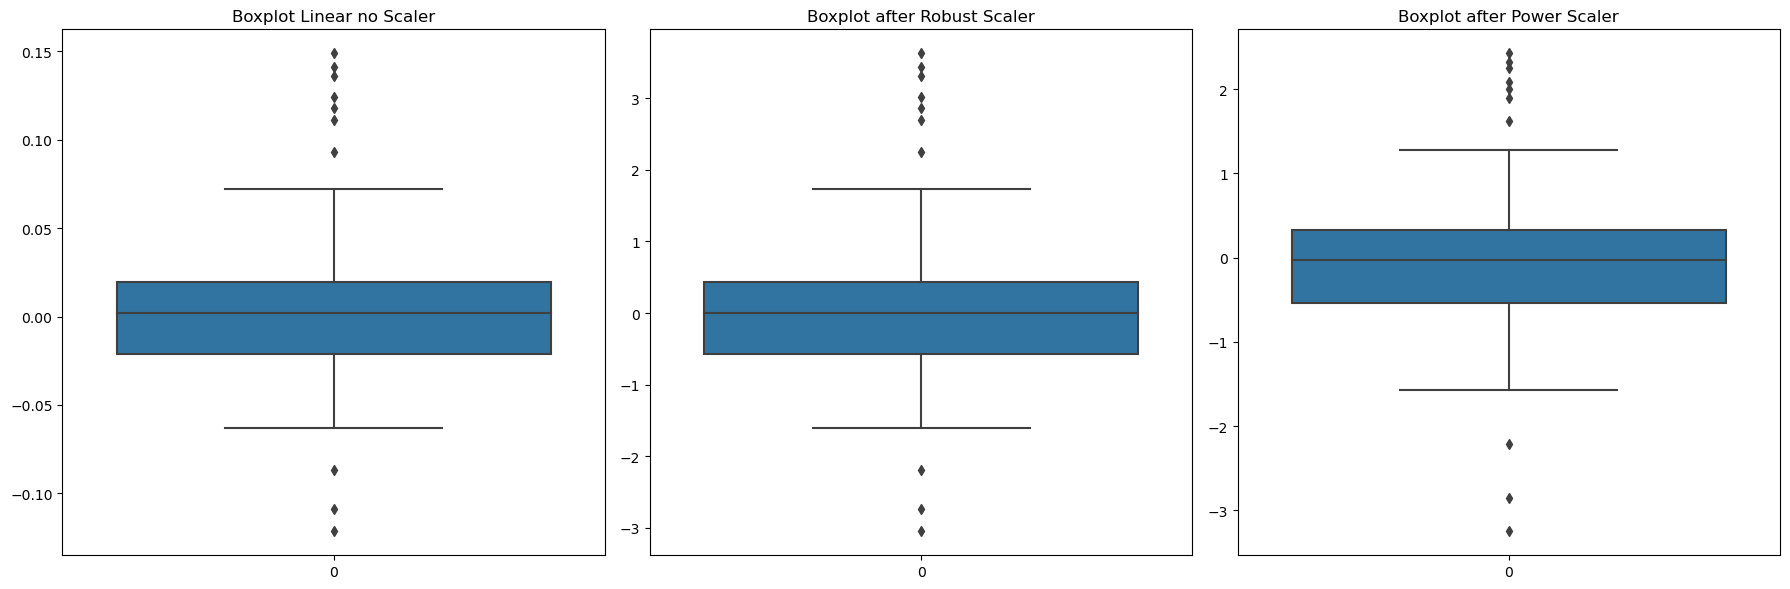

In [125]:
# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.histplot(pandas_df1['weighted_sentiment_cubic_interp'], kde=True)
plt.title('Distribution in Cubic no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.histplot(pandas_df1['robust_sentiments'], kde=True)
plt.title('Distribution after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.histplot(pandas_df1['power_sentiments'], kde=True)
plt.title('Distribution after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.boxplot(pandas_df1['weighted_sentiment_cubic_interp'])
plt.title('Boxplot Linear no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.boxplot(pandas_df1['robust_sentiments'])
plt.title('Boxplot after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.boxplot(pandas_df1['power_sentiments'])
plt.title('Boxplot after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

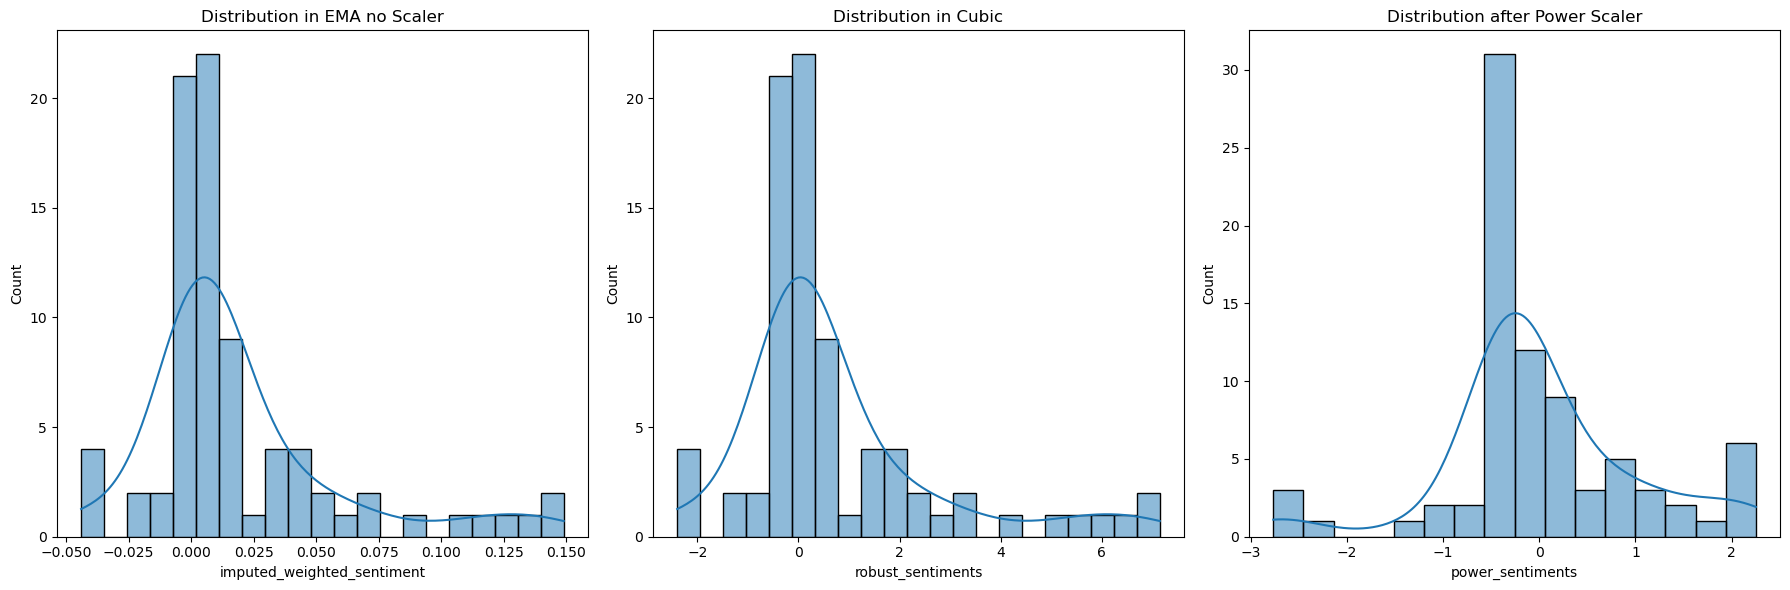

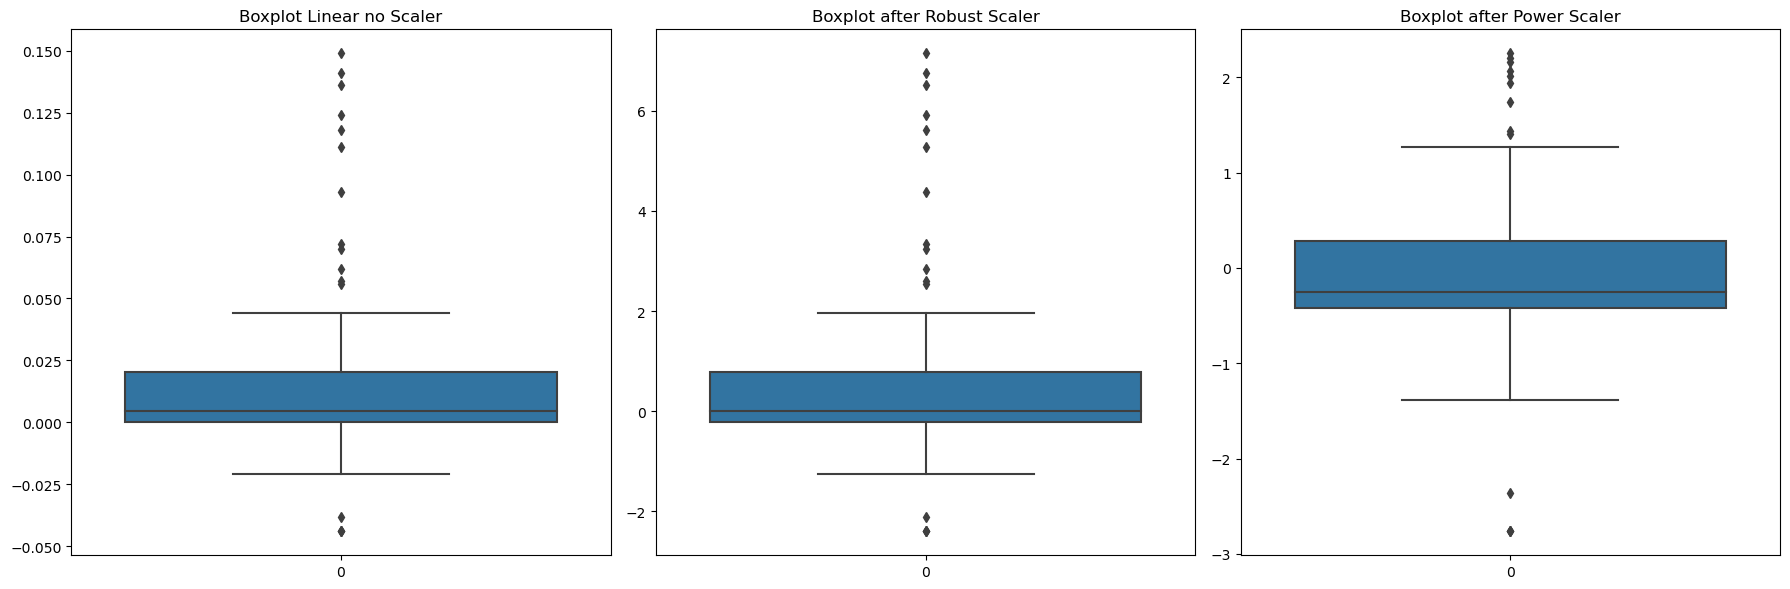

In [126]:
# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.histplot(pandas_df2['imputed_weighted_sentiment'], kde=True)
plt.title('Distribution in EMA no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.histplot(pandas_df2['robust_sentiments'], kde=True)
plt.title('Distribution in Cubic')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.histplot(pandas_df2['power_sentiments'], kde=True)
plt.title('Distribution after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.boxplot(pandas_df2['imputed_weighted_sentiment'])
plt.title('Boxplot Linear no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.boxplot(pandas_df2['robust_sentiments'])
plt.title('Boxplot after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.boxplot(pandas_df2['power_sentiments'])
plt.title('Boxplot after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

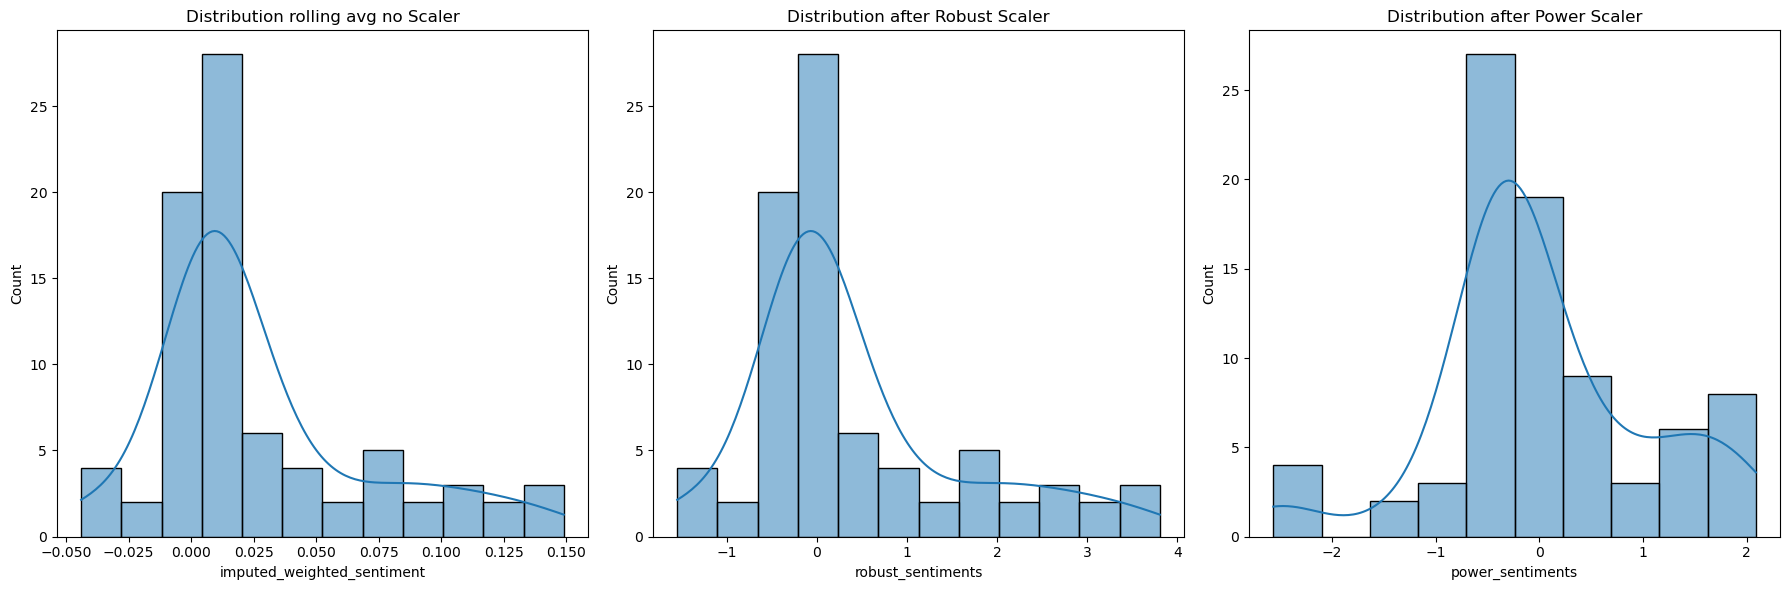

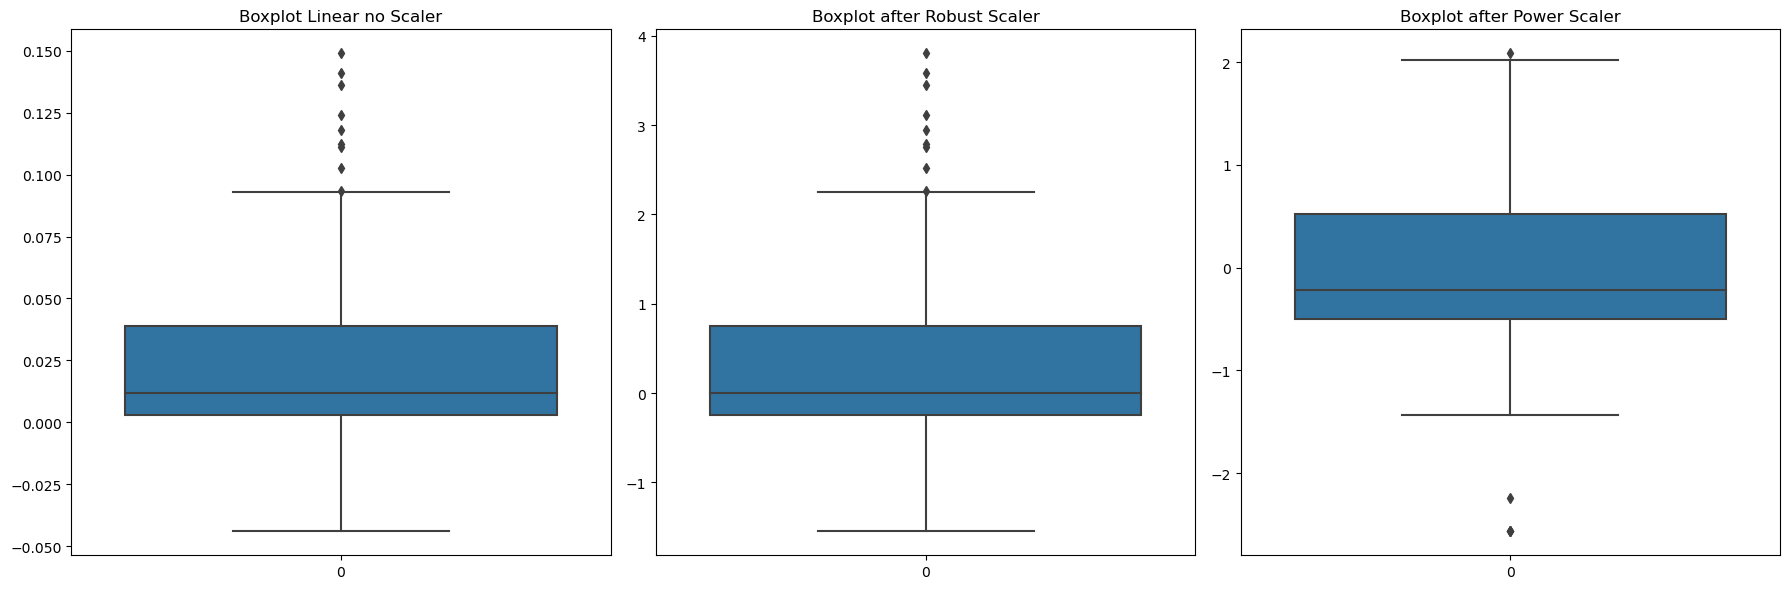

In [127]:
# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.histplot(pandas_df3['imputed_weighted_sentiment'], kde=True)
plt.title('Distribution rolling avg no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.histplot(pandas_df3['robust_sentiments'], kde=True)
plt.title('Distribution after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.histplot(pandas_df3['power_sentiments'], kde=True)
plt.title('Distribution after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.boxplot(pandas_df3['imputed_weighted_sentiment'])
plt.title('Boxplot Linear no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.boxplot(pandas_df3['robust_sentiments'])
plt.title('Boxplot after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.boxplot(pandas_df3['power_sentiments'])
plt.title('Boxplot after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

By analysing the line plots the imputation techniques:

- Interpolation: As observed in the next code and lineplot, it presented the expected results adding scores in a linear way from on sentiment score to the other. 
- Cubic: The method added more variability to the dataframe, especially with a huge spike (negative) at the last quarter.  
- EMA: The results are similar provided by the linear method, despite trying different alpha values (range between 0.1 and 1). However, is the one that yielded the smallest StdDev.
- Rolling Weighted Average: The approach presented scores that it does not add much variability to the scores and do not introduce huge spikes. 

Based on the this features the rolling weighted average will be the chosen method of imputation of missing sentiment scores, taking into account the volume of tweets. But also, visually is the one that better represented the same pattern as the original.  

In [128]:
final_df = pandas_df3
final_df.head()

,daily_records,weight,weighted_sentiment,imputed_weighted_sentiment,re_scores,robust_sentiments,power_sentiments
0,2009-04-06,0.030010,0.003,0.003000,0.003000,-0.244884,-0.501270
1,2009-04-07,0.155140,0.016,0.016000,0.016000,0.115806,-0.087991
2,2009-04-08,0.171115,NaN,0.007220,0.007220,-0.127795,-0.360869
3,2009-04-09,0.171115,NaN,0.004877,0.004877,-0.192793,-0.438035
4,2009-04-10,0.171115,NaN,0.003683,0.003683,-0.225945,-0.478135


In [136]:
final_df = final_df.drop(['weight', 'weighted_sentiment', 'imputed_weighted_sentiment','re_scores', 'robust_sentiments'], axis=1)

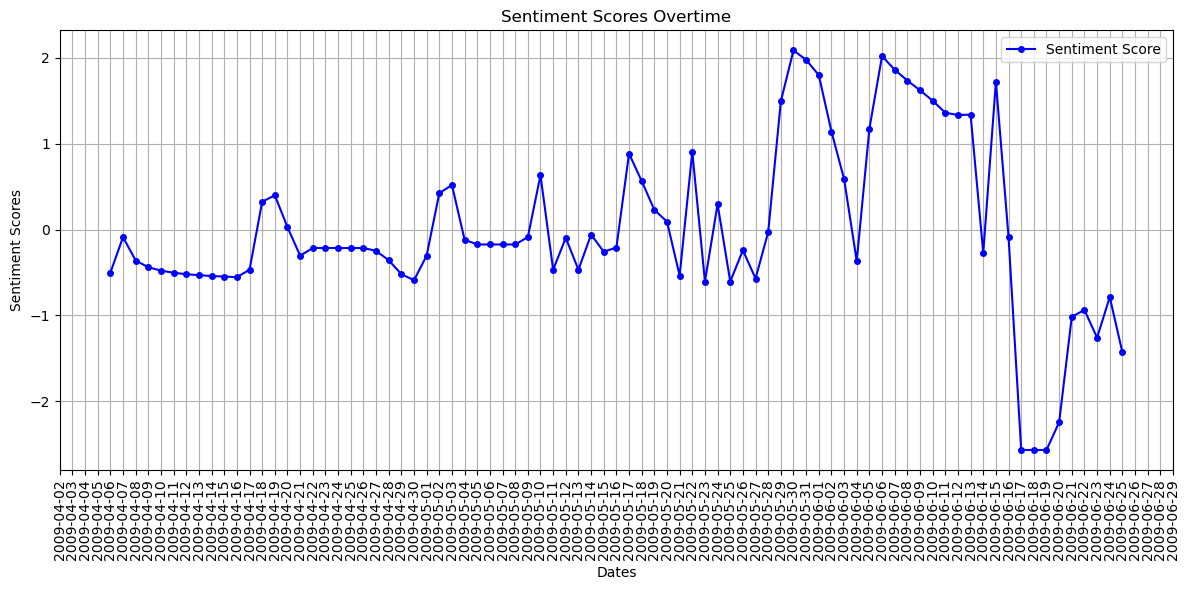

In [130]:
import matplotlib.dates as mdates

# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(final_df['daily_records'], final_df['power_sentiments'], label='Sentiment Score', marker='o', markersize=4, color='blue')
plt.xlabel('Dates')
plt.ylabel('Sentiment Scores')
plt.title('Sentiment Scores Overtime')
plt.legend()
plt.grid(True)

# Set x-axis to show all the recorded dates. 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Shows a date every 15 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
 # Increases readability.
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

With all the gaps filled the next step is to investigate seasonality and trends in the sentiment scores overtime. But, through the line plot it is not observable trends or seasonality, thus by performing the seasonal decompose to support it.

In [150]:
# Convert the column to numeric, forcing non-numeric values to NaN, then drop any NaNs
#your_time_series = pd.to_numeric(final_df['imputed_weighted_sentiment'], errors='coerce').dropna()

# Ensure the series is indexed by time
final_df.index = pd.date_range(start='2009-04-06', periods=len(final_df), freq='D')


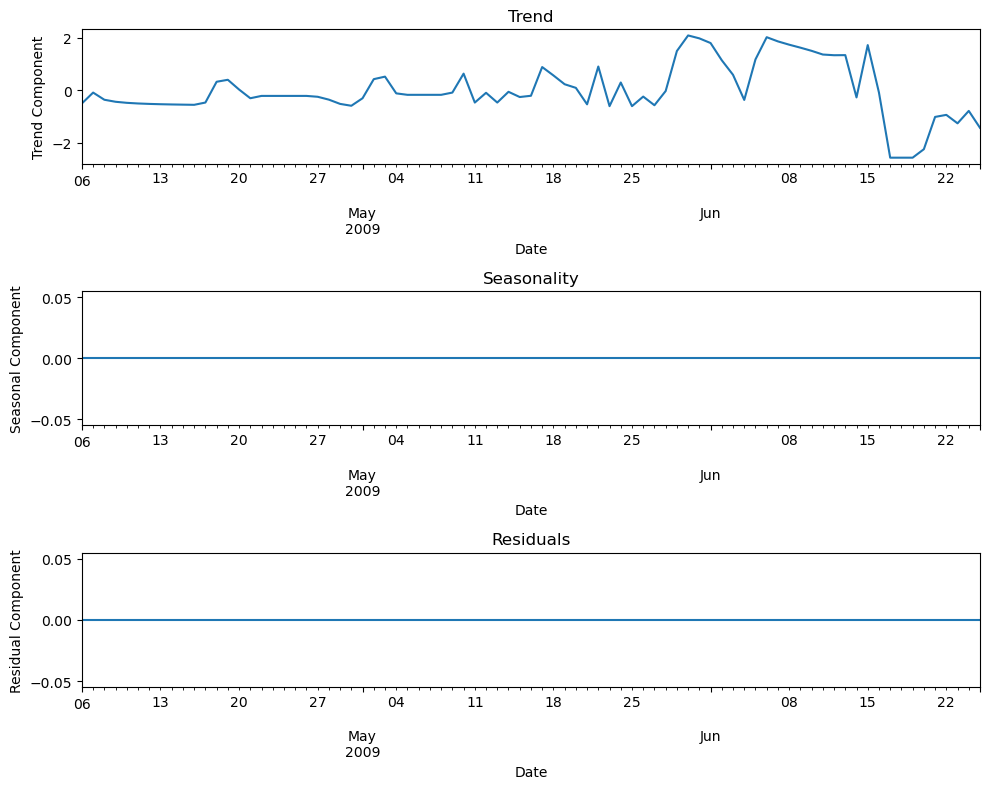

In [151]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the time series
decomposition = seasonal_decompose(final_df['power_sentiments'], 
                                   model='additive', 
                                   period=1,  # Assuming no known seasonality period from the sample
                                   extrapolate_trend='freq')

# Plotting the components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
decomposition.trend.plot(ax=ax1)
ax1.set_title('Trend')
ax1.set_xlabel('Date')
ax1.set_ylabel('Trend Component')

decomposition.seasonal.plot(ax=ax2)
ax2.set_title('Seasonality')
ax2.set_xlabel('Date')
ax2.set_ylabel('Seasonal Component')

decomposition.resid.plot(ax=ax3)
ax3.set_title('Residuals')
ax3.set_xlabel('Date')
ax3.set_ylabel('Residual Component')

plt.tight_layout()
plt.show()

In [131]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test
adf_test = adfuller(final_df['power_sentiments'], autolag='AIC')

adf_result = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4]
}

adf_result


{'Test Statistic': -3.124298632911577,
 'p-value': 0.024806462765567788,
 'Lags Used': 0,
 'Number of Observations Used': 80,
 'Critical Values': {'1%': -3.5148692050781247,
  '5%': -2.8984085156250003,
  '10%': -2.58643890625}}

- The ADFuller test resulted in p value below 0.05, rejecting the null hypothesis, thus indicating stationarity.
- The test also shows that the statistic value is bellow the value of 5% (critical value), having 85% certainty of stationary.

<Figure size 1400x700 with 0 Axes>

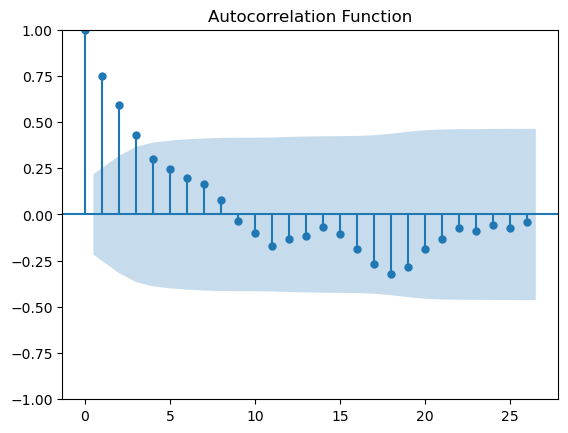

<Figure size 1400x700 with 0 Axes>

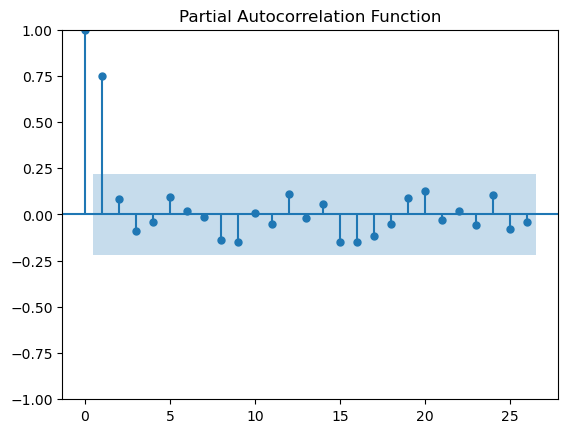

In [132]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# rule of thumb (round 1/3 of observations) for 80 observations
n_lags = int(80 / 3)

# Plot the ACF
plt.figure(figsize=(14, 7))
plot_acf(final_df['power_sentiments'], lags=n_lags, alpha=0.05)
plt.title('Autocorrelation Function')
plt.show()

# Plot the PACF
plt.figure(figsize=(14, 7))
plot_pacf(final_df['power_sentiments'], lags=n_lags, alpha=0.05, method='ywm')
plt.title('Partial Autocorrelation Function')
plt.show()



In [137]:
# Split the data into train and test sets
train_size = int(len(final_df) * 0.9)
train, test = final_df[0:train_size], final_df[train_size:]

In [154]:
from statsmodels.tsa.ar_model import AutoReg

# Fit an AR(1) model
model = AutoReg(train['power_sentiments'], lags=1)
model_fit = model.fit()
    
# Summary of the model
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:       power_sentiments   No. Observations:                   72
Model:                     AutoReg(1)   Log Likelihood                 -63.905
Method:               Conditional MLE   S.D. of innovations              0.595
Date:                Mon, 13 Nov 2023   AIC                            133.810
Time:                        22:40:40   BIC                            140.598
Sample:                             1   HQIC                           136.509
                                   72                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0772      0.073      1.055      0.291      -0.066       0.221
power_sentiments.L1     0.6723      0.087      7.718      0.000       0.502       0.843
                

MSE: 3.9507028689139796
RMSE: 1.987637509435254
MAE: 1.8714349641092727


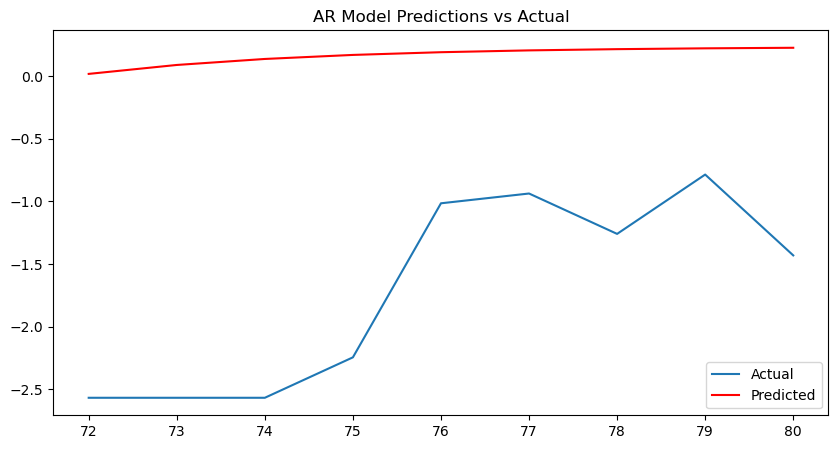

In [156]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions
start = len(train)
end = len(train) + len(test) - 1
predictions = model_fit.predict(start=start, end=end, dynamic=False)

# Calculate metrics
mse = mean_squared_error(test['power_sentiments'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['power_sentiments'], predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test['power_sentiments'], label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.legend()
plt.title('AR Model Predictions vs Actual')
plt.show()

In [157]:
import itertools

# Define the range of lags to test
lag_values = range(1, 10)  # for example, testing lags 1 to 9
aic_values = []
bic_values = []

for lag in lag_values:
    model = AutoReg(train['power_sentiments'], lags=lag)
    model_fit = model.fit()
    aic_values.append(model_fit.aic)
    bic_values.append(model_fit.bic)

# Find the optimal lag with the lowest AIC
optimal_lag_aic = lag_values[aic_values.index(min(aic_values))]
optimal_lag_bic = lag_values[bic_values.index(min(bic_values))]

print(f'Optimal Lag by AIC: {optimal_lag_aic}')
print(f'Optimal Lag by BIC: {optimal_lag_bic}')

Optimal Lag by AIC: 9
Optimal Lag by BIC: 2


                            AutoReg Model Results                             
Dep. Variable:       power_sentiments   No. Observations:                   72
Model:                     AutoReg(9)   Log Likelihood                 -49.713
Method:               Conditional MLE   S.D. of innovations              0.533
Date:                Mon, 13 Nov 2023   AIC                            121.425
Time:                        23:20:20   BIC                            145.000
Sample:                             9   HQIC                           130.697
                                   72                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0872      0.073      1.198      0.231      -0.055       0.230
power_sentiments.L1     0.4403      0.127      3.468      0.001       0.191       0.689
power_sentiments

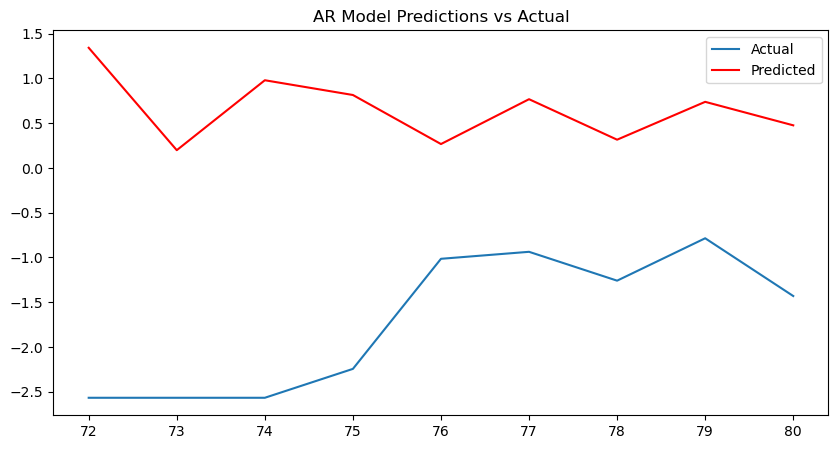

In [174]:
# Fit an AR(9) model
model2 = AutoReg(train['power_sentiments'], lags=9)
model_fit2 = model2.fit()
    
# Summary of the model
print(model_fit2.summary())

# Make predictions
start = len(train)
end = len(train) + len(test) - 1
predictions = model_fit2.predict(start=start, end=end, dynamic=False)

# Calculate metrics
mse = mean_squared_error(test['power_sentiments'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['power_sentiments'], predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test['power_sentiments'], label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.legend()
plt.title('AR Model Predictions vs Actual')
plt.show()

                               SARIMAX Results                                
Dep. Variable:       power_sentiments   No. Observations:                   72
Model:                 ARIMA(3, 0, 1)   Log Likelihood                 -60.840
Date:                Mon, 13 Nov 2023   AIC                            133.679
Time:                        23:25:04   BIC                            147.339
Sample:                             0   HQIC                           139.118
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2006      0.324      0.620      0.535      -0.434       0.835
ar.L1          0.3228      0.817      0.395      0.693      -1.278       1.923
ar.L2          0.4984      0.394      1.266      0.2

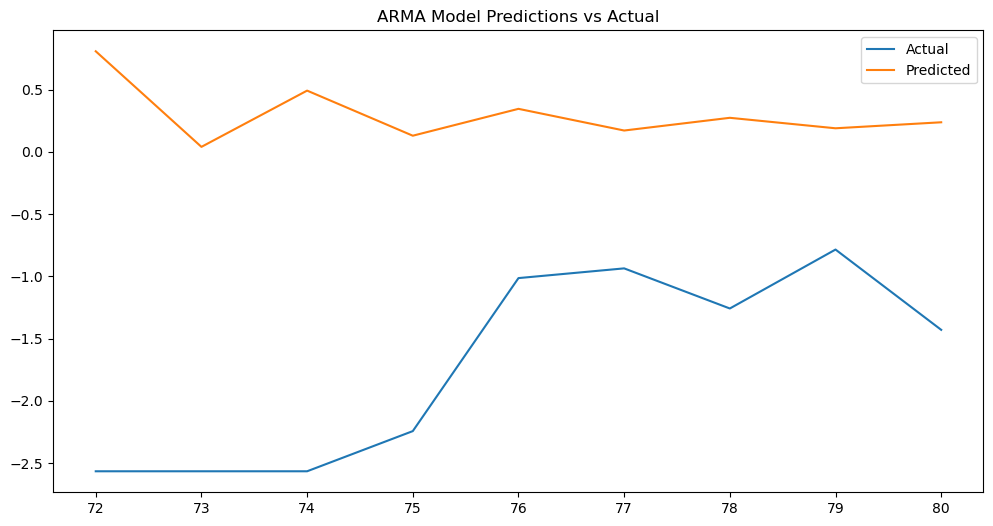

MSE: 4.701229781078441
RMSE: 2.1682319481730823
MAE: 2.0057802038123698


In [181]:
from statsmodels.tsa.arima.model import ARIMA
p = 3 # (from PACF)
q = 1 # (from ACF)
d = 0 # The time series is stationary, so d is 0

# Fit the ARMA model using the training data
model = ARIMA(train['power_sentiments'], order=(p, d, q))
model_fit = model.fit()

# Print out the summary of the model
print(model_fit.summary())

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test['power_sentiments'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate and print out the error metrics
mse = mean_squared_error(test['power_sentiments'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['power_sentiments'], predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

In [182]:
import itertools
import warnings

warnings.filterwarnings("ignore")

# Define the range of values for p and q to try (0-9).
p_range = range(9) 
q_range = range(9)  
aic_values = []

# Grid search over p_range and q_range
for p in p_range:
    for q in q_range:
        try:
            # Fit the ARMA model with the current p and q values
            model = ARIMA(train['power_sentiments'], order=(p, 0, q))
            model_fit = model.fit()
            # Append the order and AIC to the list
            aic_values.append((model_fit.aic, (p, q)))
        except:  # Catching all exceptions is not best practice, but useful for illustration
            continue

# Sort the list of AIC values in ascending order (the lower the better)
aic_values.sort()

# Get the top 5 models with the lowest AIC values
top_5_models = aic_values[:5]

print("Top 5 ARMA models by AIC:")
for model_aic, order in top_5_models:
    print(f'ARMA{order} with AIC: {model_aic}')


Top 5 ARMA models by AIC:
ARMA(4, 8) with AIC: 123.67878053800672
ARMA(2, 6) with AIC: 123.73611565227685
ARMA(8, 2) with AIC: 124.58900584399933
ARMA(0, 4) with AIC: 124.65161352798762
ARMA(5, 4) with AIC: 124.70484786185715


                               SARIMAX Results                                
Dep. Variable:       power_sentiments   No. Observations:                   72
Model:                 ARIMA(4, 0, 8)   Log Likelihood                 -47.839
Date:                Mon, 13 Nov 2023   AIC                            123.679
Time:                        23:37:10   BIC                            155.552
Sample:                             0   HQIC                           136.368
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1030      0.493      0.209      0.834      -0.863       1.069
ar.L1         -0.1631      0.281     -0.581      0.561      -0.713       0.387
ar.L2          1.0825      0.235      4.613      0.0

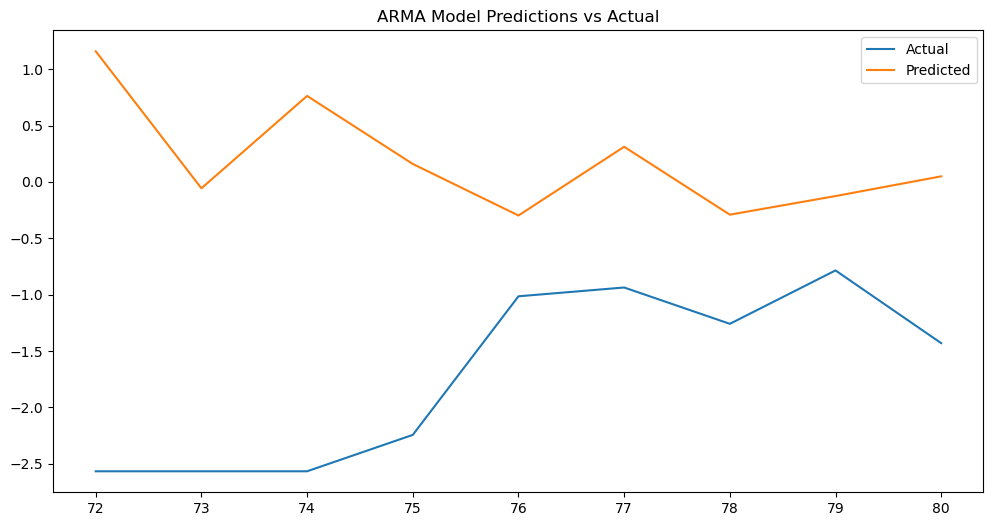

MSE: 4.740638539566901
RMSE: 2.177300746237621
MAE: 1.8932402864998545


In [188]:
p = 4 # (from PACF)
q = 8 # (from ACF)
d = 0 # The time series is stationary, so d is 0

# Fit the ARMA model using the training data
model = ARIMA(train['power_sentiments'], order=(p, d, q))
model_fit = model.fit()

# Print out the summary of the model
print(model_fit.summary())

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test['power_sentiments'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate and print out the error metrics
mse = mean_squared_error(test['power_sentiments'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['power_sentiments'], predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

                               SARIMAX Results                                
Dep. Variable:       power_sentiments   No. Observations:                   72
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -64.162
Date:                Mon, 13 Nov 2023   AIC                            132.324
Time:                        23:53:39   BIC                            136.849
Sample:                             0   HQIC                           134.124
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4215      0.074     -5.676      0.000      -0.567      -0.276
sigma2         0.3558      0.047      7.540      0.000       0.263       0.448
Ljung-Box (L1) (Q):                   0.05   Jarque-

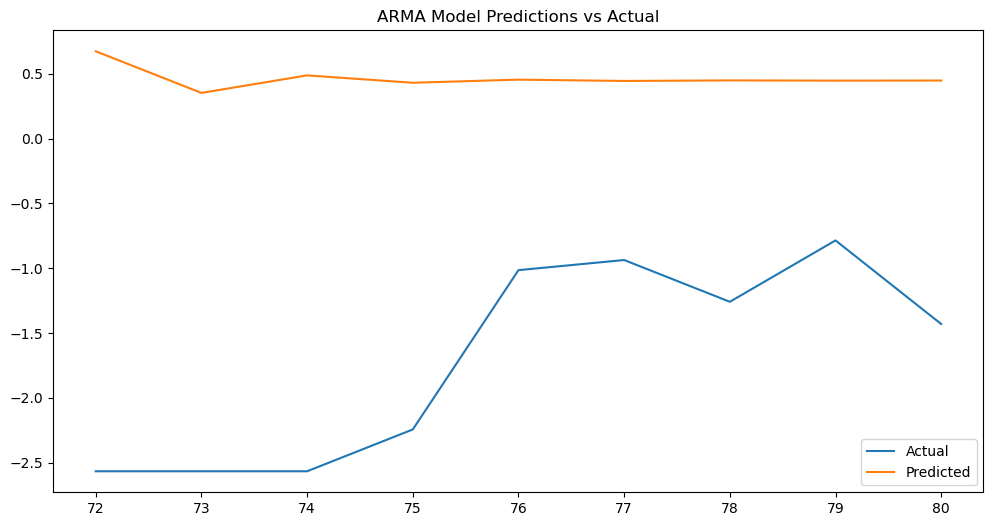

MSE: 5.283545131838936
RMSE: 2.2985963394730566
MAE: 2.1735285177139616


In [197]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA(1,0,1) model
model = ARIMA(train['power_sentiments'], order=(1, 1, 0))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test['power_sentiments'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate and print out the error metrics
mse = mean_squared_error(test['power_sentiments'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['power_sentiments'], predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

In [196]:
from pmdarima import auto_arima
import pmdarima as pm

# Fit the auto_arima model
model = pm.auto_arima(train['power_sentiments'], start_p=0, start_q=0, max_p=8, max_d=1, max_q=8, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore", trace=True)

# Print the best model's AIC
print(f'Best ARIMA model by auto_arima: {model} with AIC: {model.aic()}')


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=144.710, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=134.269, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=134.874, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=142.716, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=135.832, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=135.396, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=137.392, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=132.324, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=133.883, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=133.448, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=132.989, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=135.445, Time=0.18 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.378 seconds
Best ARIMA model by auto_arima:  ARIMA(1,1,0)(0,0,0)[0]           with AIC: 132.32395823810066


In [194]:
warnings.filterwarnings("ignore")

# Define the range of values for p, d, and q to try
p = range(0, 9)  
d = range(0, 2)  
q = range(0, 9)  

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None
best_model = None

# Grid search over pdq combinations
for combination in pdq:
    try:
        model = ARIMA(train['power_sentiments'], order=combination)
        results = model.fit()
        
        # Compare AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = combination
            best_model = results
    except:
        continue

print(f'Best ARIMA model: ARIMA{best_pdq} with AIC: {best_aic}')


Best ARIMA model: ARIMA(0, 1, 6) with AIC: 120.07531037800597


In [ ]:
import pmdarima as pm

# Assuming 'train' is your training dataset and 'power_sentiments' is the column with time series data
# 'seasonal' is set to False assuming that the time series is not seasonal.

model = pm.auto_arima(train['power_sentiments'],
                      start_p=0, start_q=0,
                      test='adf',       # Use adftest to find optimal 'd'
                      max_p=3, max_q=3, # Maximum p and q
                      m=1,              # Frequency of the series
                      d=None,           # Let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

# The model can be used to make predictions as follows:
# Assuming 'test' is your test dataset and it includes the 'power_sentiments' column
forecast = model.predict(n_periods=len(test['power_sentiments']))


                               SARIMAX Results                                
Dep. Variable:       power_sentiments   No. Observations:                   72
Model:                 ARIMA(0, 1, 6)   Log Likelihood                 -53.038
Date:                Mon, 13 Nov 2023   AIC                            120.075
Time:                        23:49:32   BIC                            135.914
Sample:                             0   HQIC                           126.374
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4999      0.101     -4.967      0.000      -0.697      -0.303
ma.L2          0.2881      0.133      2.171      0.030       0.028       0.548
ma.L3         -0.7488      0.149     -5.021      0.0

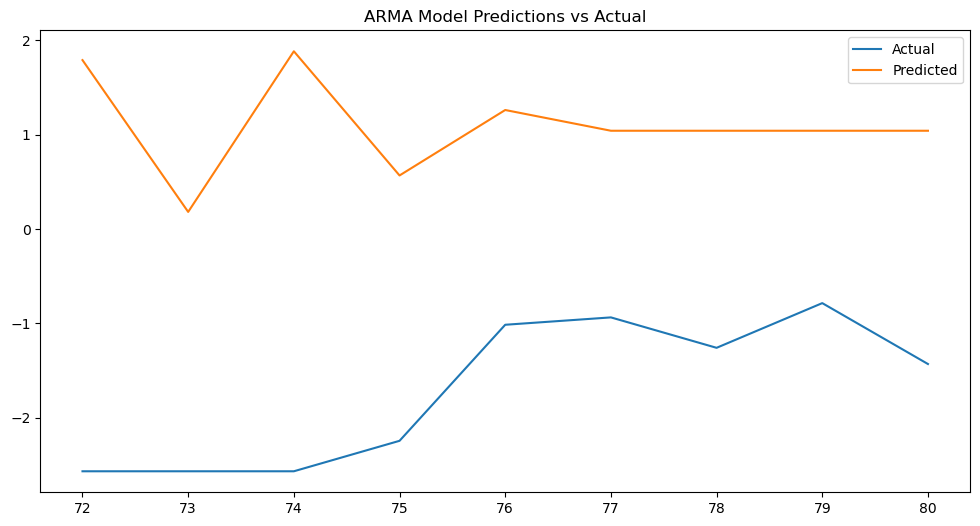

MSE: 8.669205453294072
RMSE: 2.9443514486715188
MAE: 2.8012149858835156


In [195]:
# Fit an ARIMA(1,0,1) model
model = ARIMA(train['power_sentiments'], order=(0, 1, 6))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test['power_sentiments'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate and print out the error metrics
mse = mean_squared_error(test['power_sentiments'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['power_sentiments'], predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

In [ ]:
AAA

In [ ]:
df.unpersist()

In [ ]:
# Write the DataFrame to a CSV file in the local file system of the Spark driver node
df.write.csv('file:///home/hduser/Desktop/CA2/pro_tweets.csv', header=True)